## EarthCARE and TCs - Composite

TODO

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
import pandas as pd 
from tqdm.notebook import tqdm
import ephem
import seaborn as sns
import re
from datetime import datetime
from pyproj import CRS, Geod

# Custom
import sys
sys.path.append('../ectools')
from ectools import ecio
from ectools import ecplot as ecplt
from ectools import colormaps

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    # 'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
    'ear_dir':     '/home/arthur/data/tropical_cyclones/earthcare/L2b/ACM_CAP_2B/',
    'ear_TCs_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/', # AC_TC files with IBT info
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/02_EARTHCARE_DIAGNOSTIC/'
}

# Open SAR
# dsg      = xr.open_dataset(PTHS['sar_pth'])

# Open EarthCARE
all_data = glob.glob(PTHS['ear_dir'] + '**/*.h5', recursive=True)
all_data.sort()

# Open EarthCARE data collocated with TCs
all_ear_wTCs = glob.glob(PTHS['ear_TCs_dir'] + '*.nc')
all_ear_wTCs.sort()

In [3]:
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

In [4]:
# Reference grid
r_star = np.linspace(0, 8, 8 * 4 + 1) # To take into account radial res. of EC considering an average Rmax of 20km

In [5]:
r_star

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  ])

In [6]:
# Scaling constants were computed manually so that
# ds.ice_water_path.plot(alpha=0.5, c='k')
# and
# (ds.ice_water_content.mean(dim='JSG_height', skipna=True)    * 26000).plot(c='tab:blue', alpha=0.3, linestyle='dashed')
# yield the same profiles
scaling_csts =  [86000, 86000, 86000, 26000, 26000, 26000, 26000, 26000, 26000] # was computed manually

  0%|          | 0/9 [00:00<?, ?it/s]

Average Rmax = 21.4 km


Text(0, 0.5, 'Ice water path (kg m-2)')

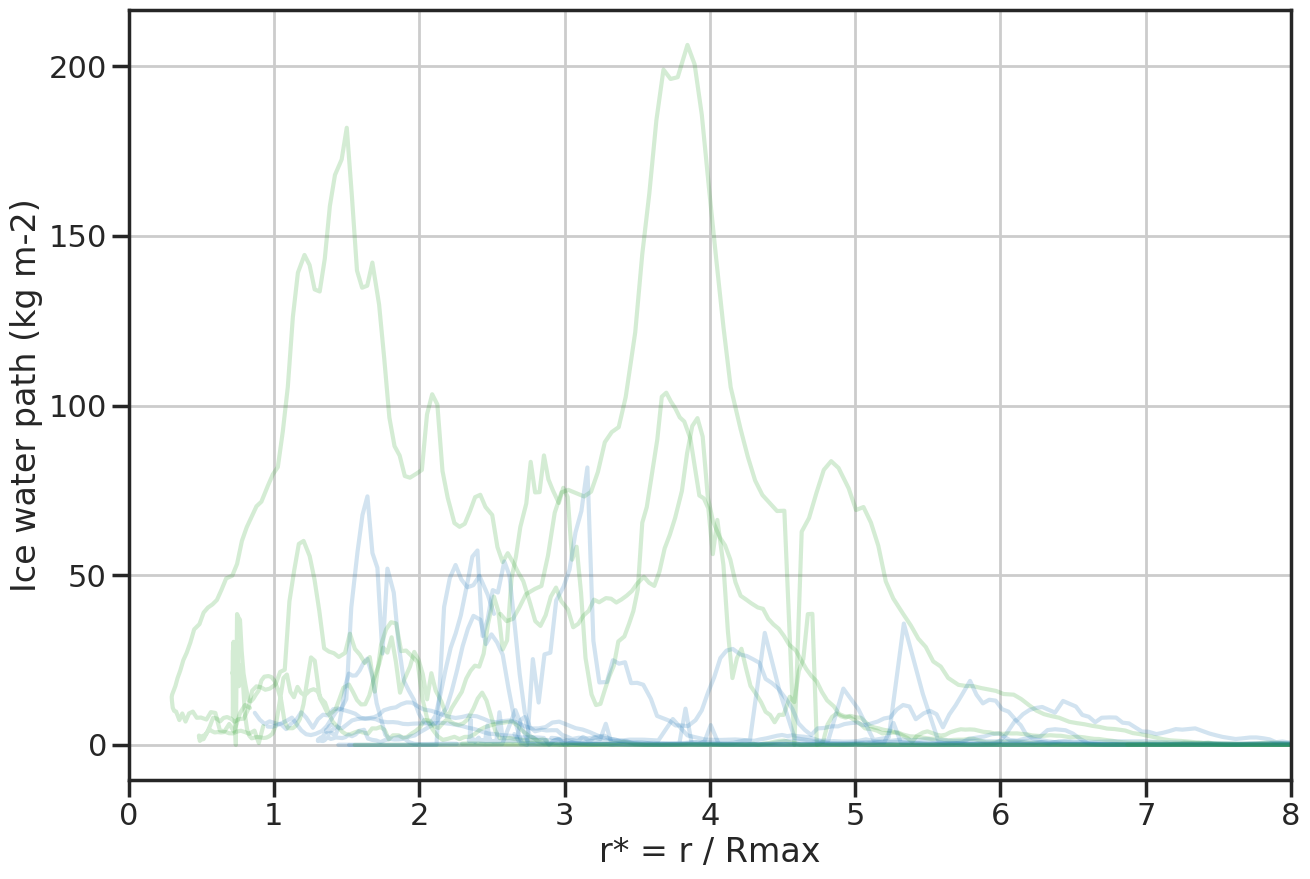

In [7]:
RMXS     = []
WPS_FRT  = [] # Water paths at storm front
WPS_RER  = [] # Water paths at storm rear

# Ice water path in radial height transect
for file in tqdm(all_data):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')

    # Find TC information
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product

    # Interpolate on polar grid
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Masks
    frt = np.array((ds.th % 360 >= 0)   & (ds.th % 360 < 180))
    rer = np.array((ds.th % 360 >= 180) & (ds.th % 360 < 360))

    # Plot
    plt.plot(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt, ds.ice_water_path.where(frt).dropna(dim='along_track'), alpha=0.2, c='tab:blue')
    plt.plot(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt, ds.ice_water_path.where(rer).dropna(dim='along_track'), alpha=0.2, c='tab:green')

    # Append
    RMXS.append(float(dst.rmx_ibt))
    try:
        WPS_FRT.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt), np.array(ds.ice_water_path.where(frt).dropna(dim='along_track'))), coords={'r_star': r_star}))
    except ValueError:
        WPS_FRT.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
    try:
        WPS_RER.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt), np.array(ds.ice_water_path.where(rer).dropna(dim='along_track'))), coords={'r_star': r_star}))
    except ValueError:
        WPS_RER.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
    
# # Concat
# dawp_frt = xr.concat(WPS_FRT, dim='idx')
# dawp_frt.mean(dim='idx').plot(c='tab:blue')
# (dawp_frt.mean(dim='idx') + dawp_frt.std(dim='idx')).plot(c='tab:blue', linestyle='dashed')

# dawp_rer = xr.concat(WPS_RER, dim='idx')
# dawp_rer.mean(dim='idx').plot(c='tab:green')
# (dawp_rer.mean(dim='idx') + dawp_rer.std(dim='idx')).plot(c='tab:green', linestyle='dashed')

# Legends
plt.xlim(0, 8)
plt.grid()
print('Average Rmax = {:.1f} km'.format(np.mean(RMXS) / 1000))
plt.xlabel('r* = r / Rmax')
plt.ylabel('Ice water path (kg m-2)')

0it [00:00, ?it/s]

Average Rmax = 21.4 km


Text(0, 0.5, 'Ice water path (kg m-2)')

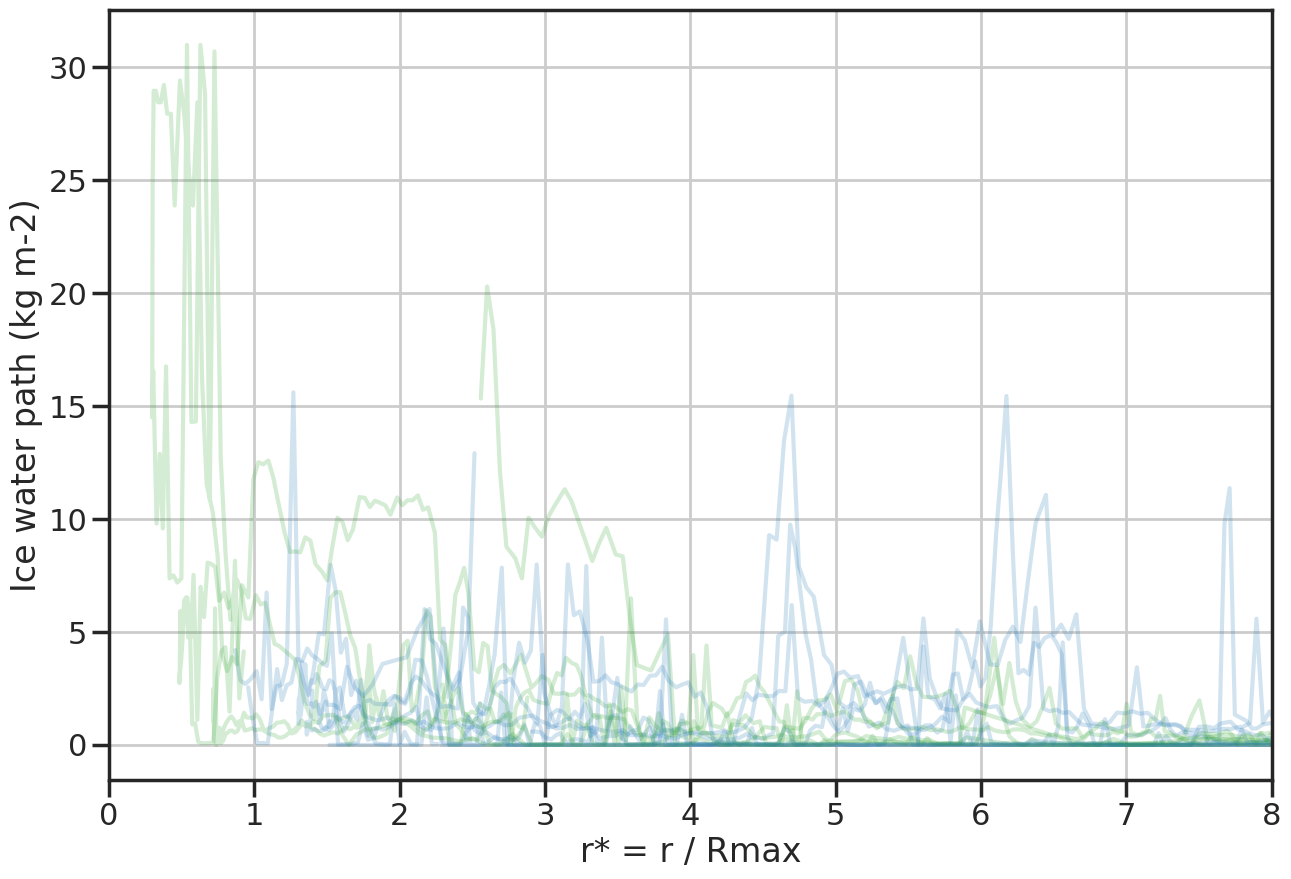

In [8]:
RMXS     = []
WPS_FRT  = [] # Water paths at storm front
WPS_RER  = [] # Water paths at storm rear

# Ice water path in radial height transect
for idx, file in tqdm(enumerate(all_data)):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')

    # Find TC information
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product

    # Interpolate on polar grid
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Masks
    frt = np.array((ds.th % 360 >= 0)   & (ds.th % 360 < 180)) & np.array(~np.isnan(ds.liquid_water_content.mean(dim='JSG_height', skipna=True)))
    rer = np.array((ds.th % 360 >= 180) & (ds.th % 360 < 360)) & np.array(~np.isnan(ds.liquid_water_content.mean(dim='JSG_height', skipna=True)))

    # Plot
    plt.plot(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt, (ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(frt).dropna(dim='along_track'), alpha=0.2, c='tab:blue')
    plt.plot(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt, (ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(rer).dropna(dim='along_track'), alpha=0.2, c='tab:green')

    # Append
    RMXS.append(float(dst.rmx_ibt))
    try:
        WPS_FRT.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt), np.array((ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(frt).dropna(dim='along_track'))), coords={'r_star': r_star}))
    except ValueError:
        WPS_FRT.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
    try:
        WPS_RER.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt), np.array((ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(rer).dropna(dim='along_track'))), coords={'r_star': r_star}))
    except ValueError:
        WPS_RER.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
    
# # Concat
# dawp_frt = xr.concat(WPS_FRT, dim='idx')
# dawp_frt.mean(dim='idx').plot(c='tab:blue')
# (dawp_frt.mean(dim='idx') + dawp_frt.std(dim='idx')).plot(c='tab:blue', linestyle='dashed')

# dawp_rer = xr.concat(WPS_RER, dim='idx')
# dawp_rer.mean(dim='idx').plot(c='tab:green')
# (dawp_rer.mean(dim='idx') + dawp_rer.std(dim='idx')).plot(c='tab:green', linestyle='dashed')

# Legends
plt.xlim(0, 8)
plt.grid()
print('Average Rmax = {:.1f} km'.format(np.mean(RMXS) / 1000))
plt.xlabel('r* = r / Rmax')
plt.ylabel('Liquid water path (kg m-2)')

0it [00:00, ?it/s]

Average Rmax = nan km


Text(0, 0.5, 'Liquid water path (kg m-2)')

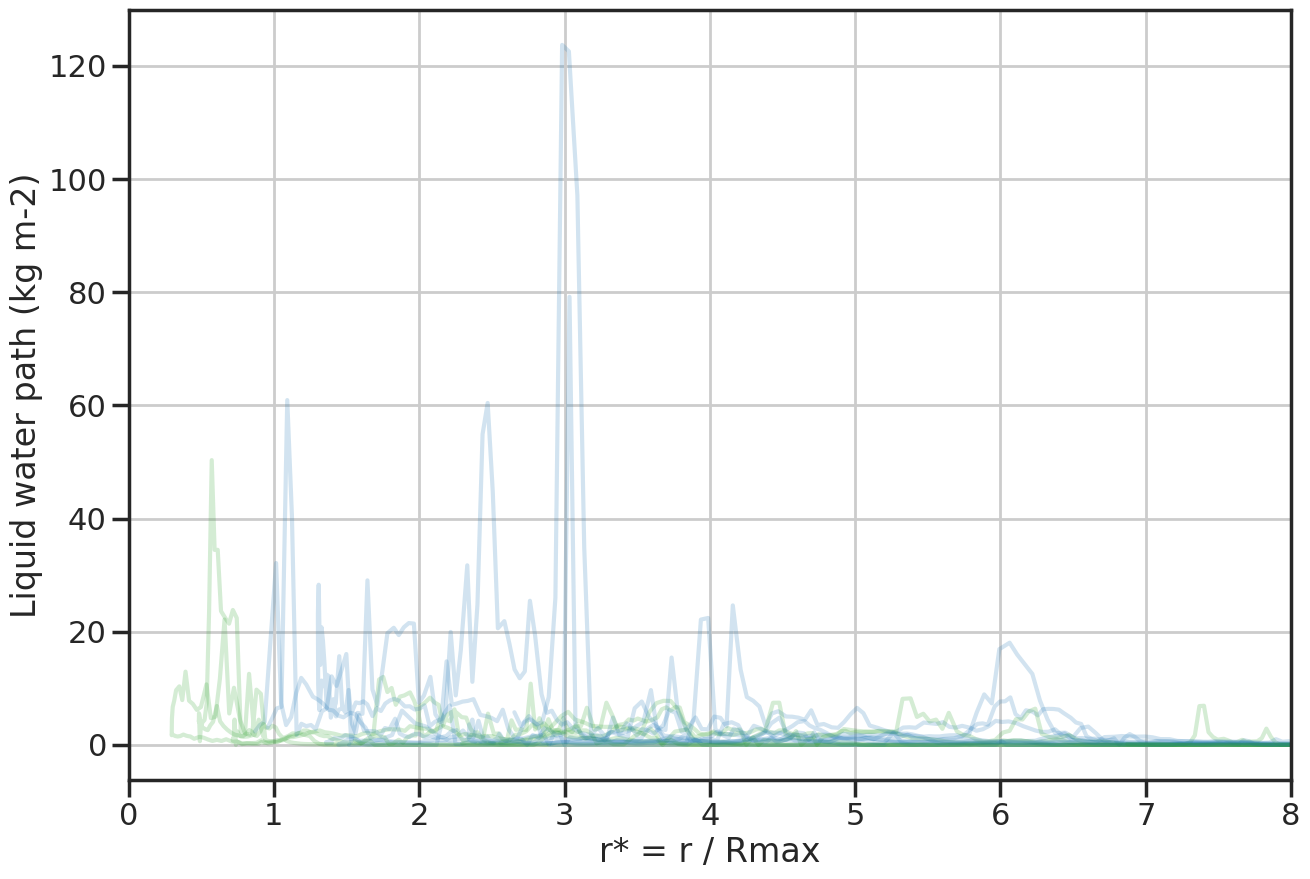

In [12]:
RMXS     = []
WPS_FRT  = [] # Water paths at storm front
WPS_RER  = [] # Water paths at storm rear

# Ice water path in radial height transect
for idx, file in tqdm(enumerate(all_data)):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')

    # Find TC information
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product

    # Interpolate on polar grid
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Masks
    frt = np.array((ds.th % 360 >= 0)   & (ds.th % 360 < 180)) & np.array(~np.isnan(ds.rain_rate.mean(dim='JSG_height', skipna=True)))
    rer = np.array((ds.th % 360 >= 180) & (ds.th % 360 < 360)) & np.array(~np.isnan(ds.rain_rate.mean(dim='JSG_height', skipna=True)))

    # Plot
    plt.plot(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt, (ds.rain_rate.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(frt).dropna(dim='along_track'), alpha=0.2, c='tab:blue')
    plt.plot(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt, (ds.rain_rate.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(rer).dropna(dim='along_track'), alpha=0.2, c='tab:green')

# Legends
plt.xlim(0, 8)
plt.grid()
print('Average Rmax = {:.1f} km'.format(np.mean(RMXS) / 1000))
plt.xlabel('r* = r / Rmax')
plt.ylabel('Liquid water path (kg m-2)')

In [13]:
# WPS_FRT  = [] # Water paths at storm front
# WPS_RER  = [] # Water paths at storm rear

# # Ice water path in radial height transect
# for file in tqdm(all_data):
#     # Open file
#     # ds = xr.open_dataset(file)
#     ds      = xr.open_dataset(file, group='/ScienceData')
    
#     oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
#     ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
#     dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product
    
#     geod_wgs84        = CRS("epsg:4326").get_geod()
#     forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
#     forward_az        = forward_az - float(dst.storm_dir_ibt)
#     th                = get_polar_theta(forward_az) # r is dr
#     ds['r']           = xr.DataArray(data=dr, dims=['ray'])
#     ds['th']          = xr.DataArray(data=th, dims=['ray'])
    
#     plt.plot(ds.r / dst.rmx_ibt, ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx], alpha=0.2, c='k')
#     # plt.plot(ds.r / 1000, ds.ice_water_content.mean(dim='JSG_height', skipna=True)    * 86000, c='tab:blue', alpha=0.5, linestyle='dashed')

#     # Append
#     frt = np.array((ds.th % 360 >= 0)   & (ds.th % 360 < 180))
#     rer = np.array((ds.th % 360 >= 180) & (ds.th % 360 < 360))
#     RMXS.append(float(dst.rmx_ibt))
#     try:
#         WPS_FRT.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(frt).dropna(dim='ray') / dst.rmx_ibt), np.array((ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(frt).dropna(dim='along_track'))), coords={'r_star': r_star}))
#     except ValueError:
#         WPS_FRT.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
#     try:
#         WPS_RER.append(xr.DataArray(data=np.interp(r_star, np.array(ds.r.where(rer).dropna(dim='ray') / dst.rmx_ibt), np.array((ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]).where(rer).dropna(dim='along_track'))), coords={'r_star': r_star}))
#     except ValueError:
#         WPS_RER.append(xr.DataArray(data=np.ones_like(r_star) * np.nan, coords={'r_star': r_star}))
    
# # Concat
# dawp_frt = xr.concat(WPS_FRT, dim='idx')
# dawp_frt.mean(dim='idx').plot(c='k')
# (dawp_frt.mean(dim='idx') + dawp_frt.std(dim='idx')).plot(c='k', linestyle='dashed')

# dawp_rer = xr.concat(WPS_RER, dim='idx')
# dawp_rer.mean(dim='idx').plot(c='k')
# (dawp_rer.mean(dim='idx') + dawp_rer.std(dim='idx')).plot(c='k', linestyle='dashed')

# # Legends
# plt.xlim(0, 8)
# plt.grid()
# plt.xlabel('r* = r / Rmax')
# plt.ylabel('Liquid water path (kg m-2)')

  0%|          | 0/9 [00:00<?, ?it/s]

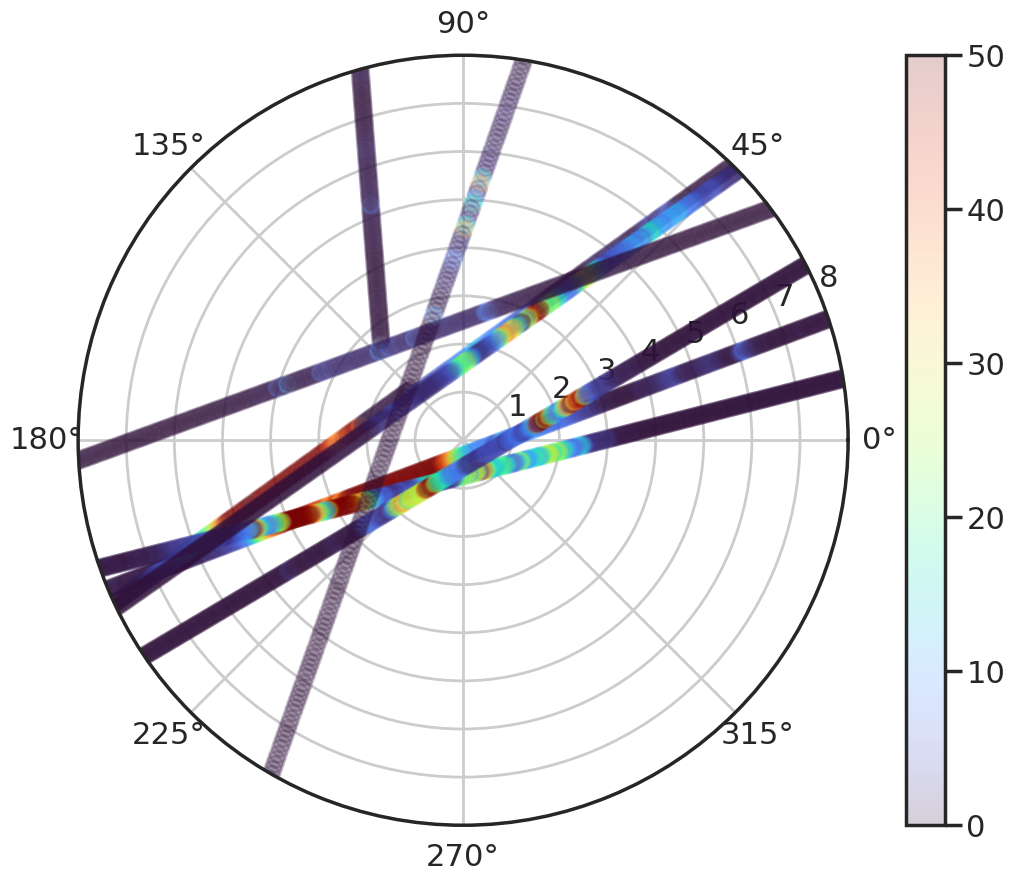

In [48]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')
    
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product
    
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # CAVEAT: Flip Southern hemisphere
    if dst.lat_ibt < 0:
        ds['th'] = 180 - ds['th']
    
    # Plot
    im = ax.scatter(np.deg2rad(ds.th), ds.r / dst.rmx_ibt, c=ds.ice_water_path, vmax=50.0, cmap='turbo', alpha=0.2)

    # Close dataset
    ds.close()

fig.colorbar(im)
ax.set_rmax(8)

# radial_label = ax.set_ylabel("r / Rmax")
# radial_label.set_zorder(10)

(array([2.553e+03, 8.300e+01, 3.300e+01, 8.700e+01, 5.000e+01, 4.100e+01,
        4.900e+01, 3.000e+01, 4.300e+01, 2.700e+01, 2.100e+01, 1.400e+01,
        2.400e+01, 1.000e+01, 9.000e+00, 8.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

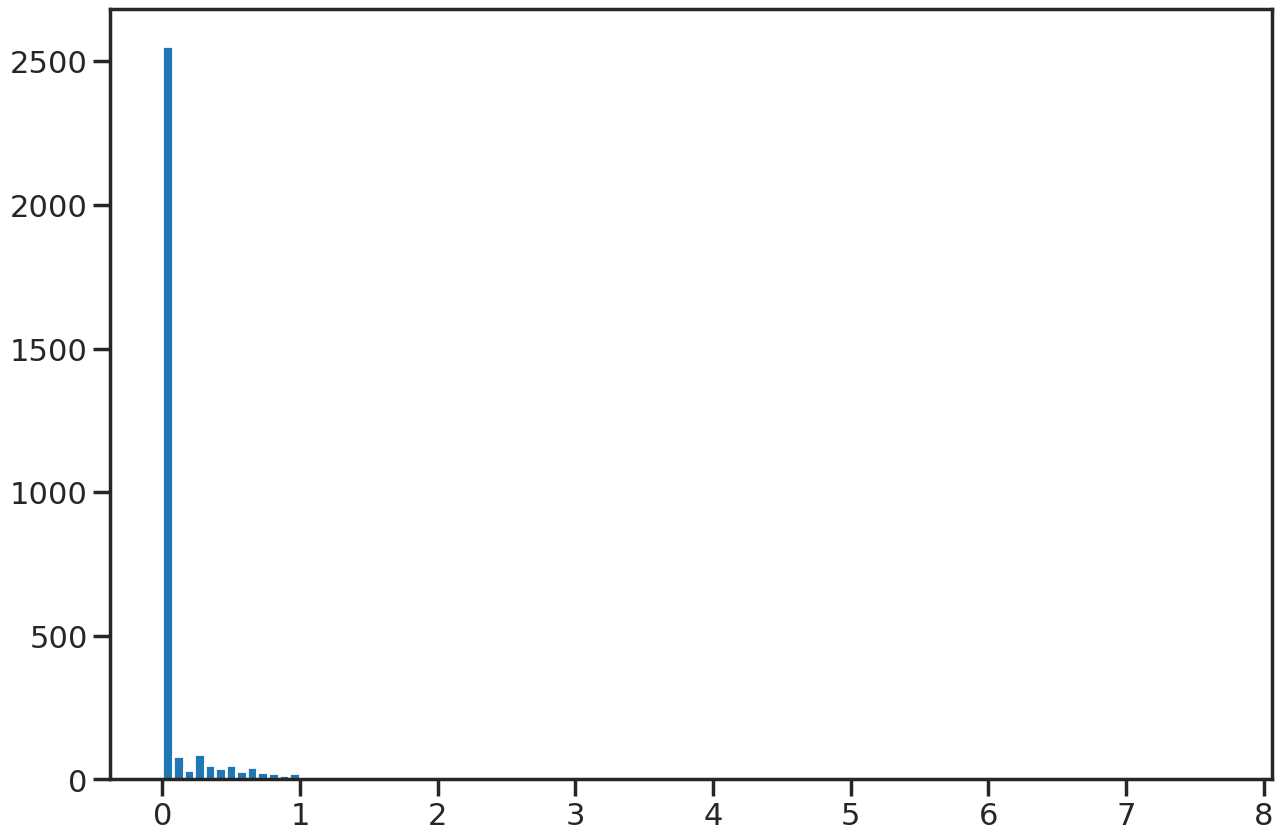

In [53]:
plt.hist(np.array(ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx]), bins=100)

0it [00:00, ?it/s]

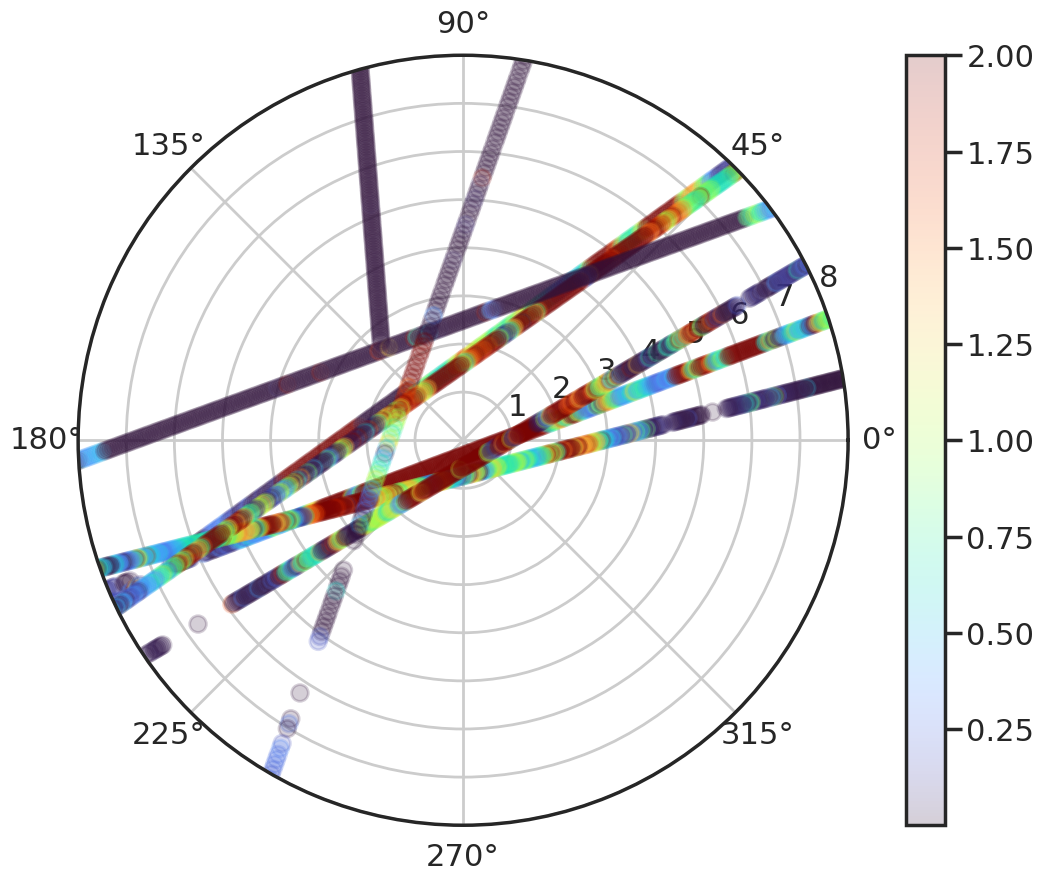

In [55]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for idx, file in tqdm(enumerate(all_data)):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')
    
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product
    
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # CAVEAT: Flip Southern hemisphere
    if dst.lat_ibt < 0:
        ds['th'] = 180 - ds['th']
    
    # Plot
    im = ax.scatter(np.deg2rad(ds.th), ds.r / dst.rmx_ibt, c=ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * scaling_csts[idx], cmap='turbo', vmax=2.0, alpha=0.2)

    # Close dataset
    ds.close()

fig.colorbar(im)
ax.set_rmax(8)

# radial_label = ax.set_ylabel("r / Rmax")
# radial_label.set_zorder(10)

0it [00:00, ?it/s]

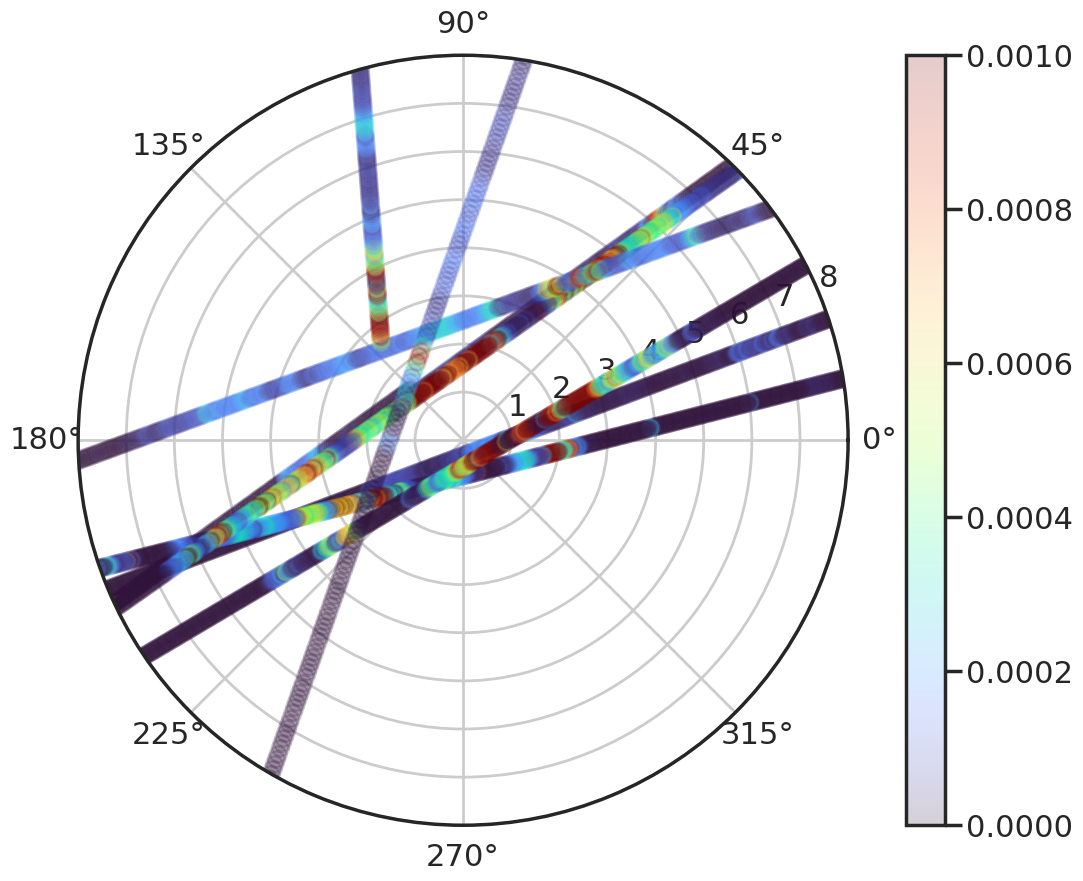

In [56]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for idx, file in tqdm(enumerate(all_data)):
    # Open file
    # ds = xr.open_dataset(file)
    ds      = xr.open_dataset(file, group='/ScienceData')
    
    oId     = os.path.basename(file).split('.')[0].split('_')[-1]     # ID of current overpass 
    ear_wTC = list(filter(lambda path: oId in path, all_ear_wTCs))[0] # Path of the AC_TC product that has the IBT info
    dst     = xr.open_dataset(ear_wTC)                                # Open this AC_TC/IBT product
    
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(dst.lon_ibt), np.ones_like(ds.latitude) * float(dst.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(dst.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # CAVEAT: Flip Southern hemisphere
    if dst.lat_ibt < 0:
        ds['th'] = 180 - ds['th']
    
    # Plot
    im = ax.scatter(np.deg2rad(ds.th), ds.r / dst.rmx_ibt, c=ds.isel(JSG_height=slice(220, None)).rain_rate.mean(dim='JSG_height'), cmap='turbo', vmax=1e-3, alpha=0.2)

    # Close dataset
    ds.close()

fig.colorbar(im)
ax.set_rmax(8)

# radial_label = ax.set_ylabel("r / Rmax")
# radial_label.set_zorder(10)

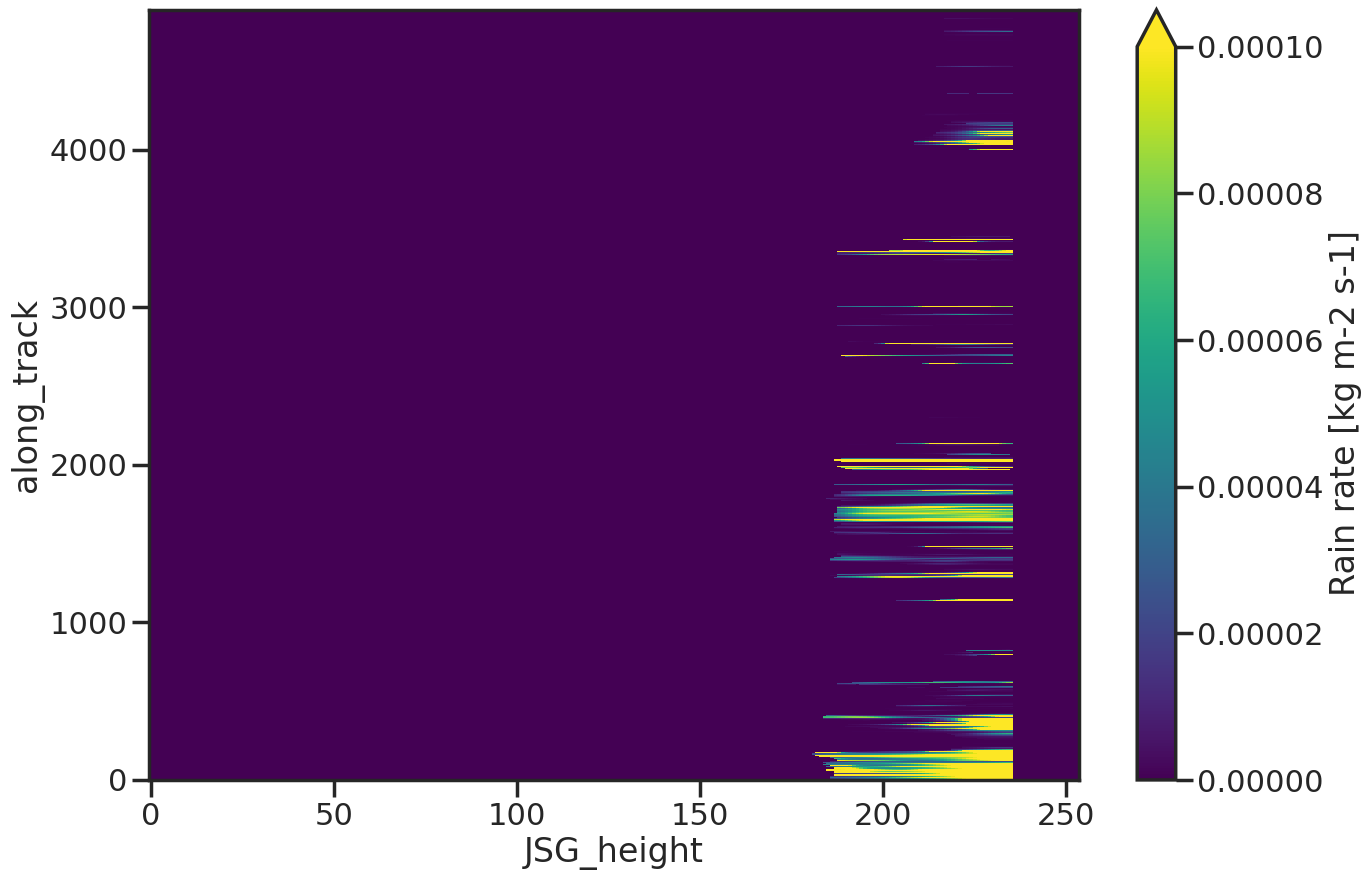

In [19]:
ds.rain_rate.plot(vmax=1e-4)

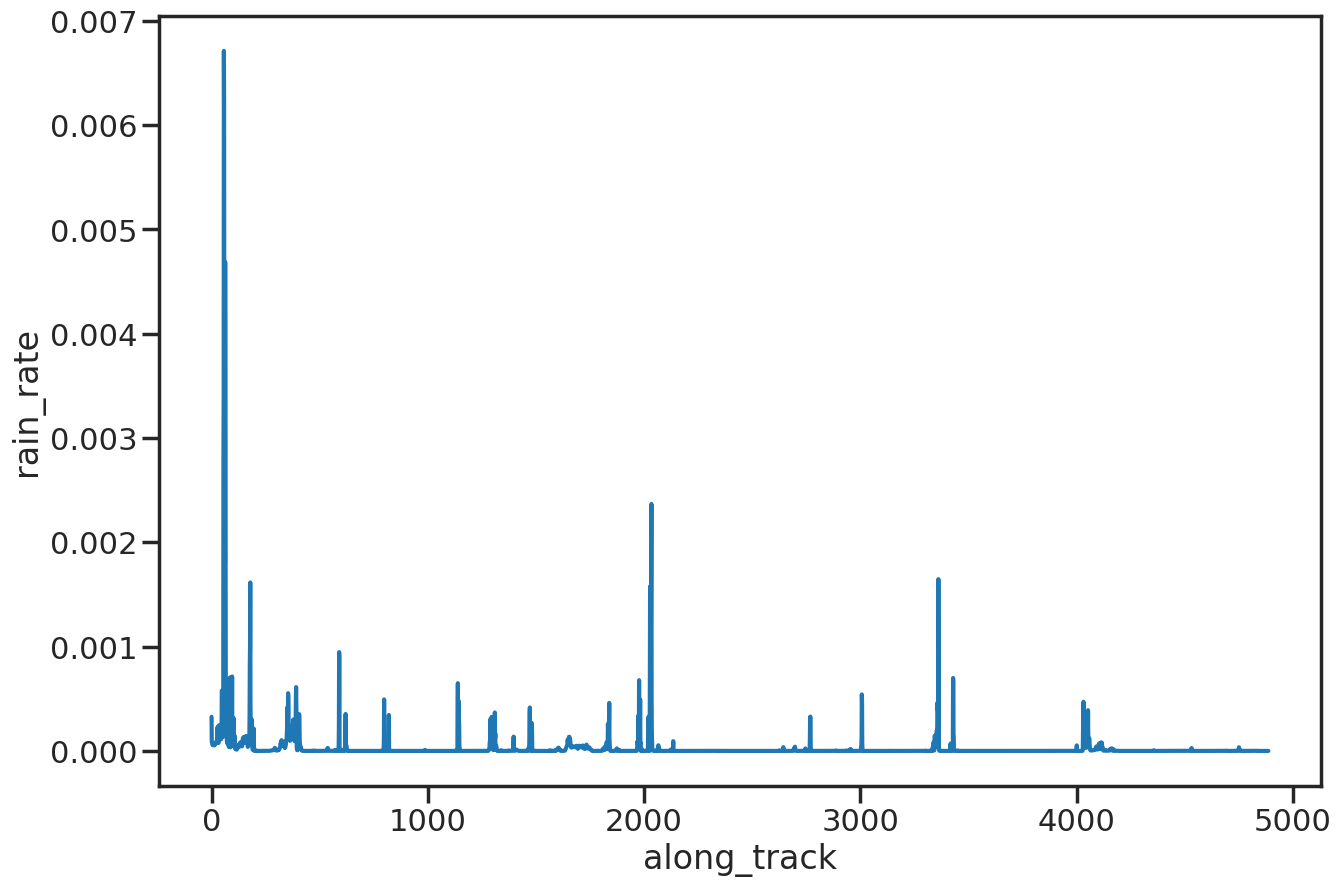

In [31]:
ds.isel(JSG_height=slice(220, None)).rain_rate.mean(dim='JSG_height').plot()

In [32]:
# plt.plot(ds.JSG_height, ds.height.mean(dim='along_track'))
# plt.xlim(200, 250)
# plt.ylim(0, 1000)
# plt.grid()

In [ ]:


ds.ice_water_path.plot(alpha=0.5, c='k')
(ds.ice_water_content.mean(dim='JSG_height', skipna=True)    * 26000).plot(c='tab:blue', alpha=0.3, linestyle='dashed')
# (ds.liquid_water_content.mean(dim='JSG_height', skipna=True) * 86000).plot(c='tab:red', alpha=0.5, linestyle='dashed')

In [ ]:
for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)
    
    # Compute polar coordinates of EarthCARE
    # We also rotate the storm
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(ds.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Plot
    ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:blue', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(8)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)    # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

In [3]:
# # Test
# all_data = ['/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc']

In [4]:
ACTC_category_colors = [sns.xkcd_rgb['silver'],         #unknown
                        sns.xkcd_rgb['reddish brown'],         #surface and subsurface
                        sns.xkcd_rgb['white'],         #clear
                        sns.xkcd_rgb['dull red'],      #rain in clutter
                        sns.xkcd_rgb['off blue'],     #snow in clutter
                        sns.xkcd_rgb['dull yellow'],   #cloud in clutter
                        sns.xkcd_rgb['dark red'],      #heavy rain',
                        sns.xkcd_rgb["navy blue"],   #heavy mixed-phase precipitation
                        sns.xkcd_rgb['light grey'],    #clear (poss. liquid) 
                        sns.xkcd_rgb['pale yellow'],   #liquid cloud
                        sns.xkcd_rgb['golden'],        #drizzling liquid
                        sns.xkcd_rgb['orange'],        #warm rain
                        sns.xkcd_rgb['bright red'],    #cold rain
                        sns.xkcd_rgb['easter purple'], # melting snow
                        sns.xkcd_rgb['dark sky blue'],        # snow (possible liquid)
                        sns.xkcd_rgb['bright blue'], # snow
                        sns.xkcd_rgb["prussian blue"],   # rimed snow (poss. liquid)
                        sns.xkcd_rgb['dark teal'],   # rimed snow and SLW
                        sns.xkcd_rgb['teal'],              # snow and SLW
                        sns.xkcd_rgb['light green'],   # supercooled liquid
                        sns.xkcd_rgb["sky blue"],      # ice (poss. liquid)
                        sns.xkcd_rgb['bright teal'],   # ice and SLW
                        sns.xkcd_rgb['light blue'],    # ice (no liquid)
                        sns.xkcd_rgb['pale blue'],     # strat. ice, PSC II
                        sns.xkcd_rgb['neon green'],    # PSC Ia
                        sns.xkcd_rgb['greenish cyan'], # PSC Ib
                        sns.xkcd_rgb['ugly green'],    # insects
                        sns.xkcd_rgb['sand'],          # dust
                        sns.xkcd_rgb['pastel pink'],   # sea salt
                        sns.xkcd_rgb['dust'],          # continental pollution
                        sns.xkcd_rgb['purpley grey'],  # smoke
                        sns.xkcd_rgb['dark lavender'], # dusty smoke
                        sns.xkcd_rgb['dusty lavender'],# dusty mix
                        sns.xkcd_rgb['pinkish grey'],  # stratospheric aerosol 1 (ash)
                        sns.xkcd_rgb['light khaki'],       # stratospheric aerosol 2 (sulphate)
                        sns.xkcd_rgb['light grey'],    # stratospheric aerosol 3 (smoke)]
                  ]

hmax = 20000

### Histogram of data w.r.t distance from center and category

In [5]:
MIN_DIS2CEN        = []
MIN_DIS2CEN_STRONG = []

for file in tqdm(all_data):
    ds = xr.open_dataset(file)

    if ds.closest_distance_to_track_center_ibt < 5000:
        print(ds.vmx_ibt.values)
        print(ds.file.item())
        print(file)

    if ds.vmx_ibt >= 33:
        MIN_DIS2CEN_STRONG.append(float(ds.closest_distance_to_track_center_ibt))
    
    MIN_DIS2CEN.append(float(ds.closest_distance_to_track_center_ibt))

    ds.close()

  0%|          | 0/418 [00:00<?, ?it/s]

32.66655269007365
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/28/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.nc


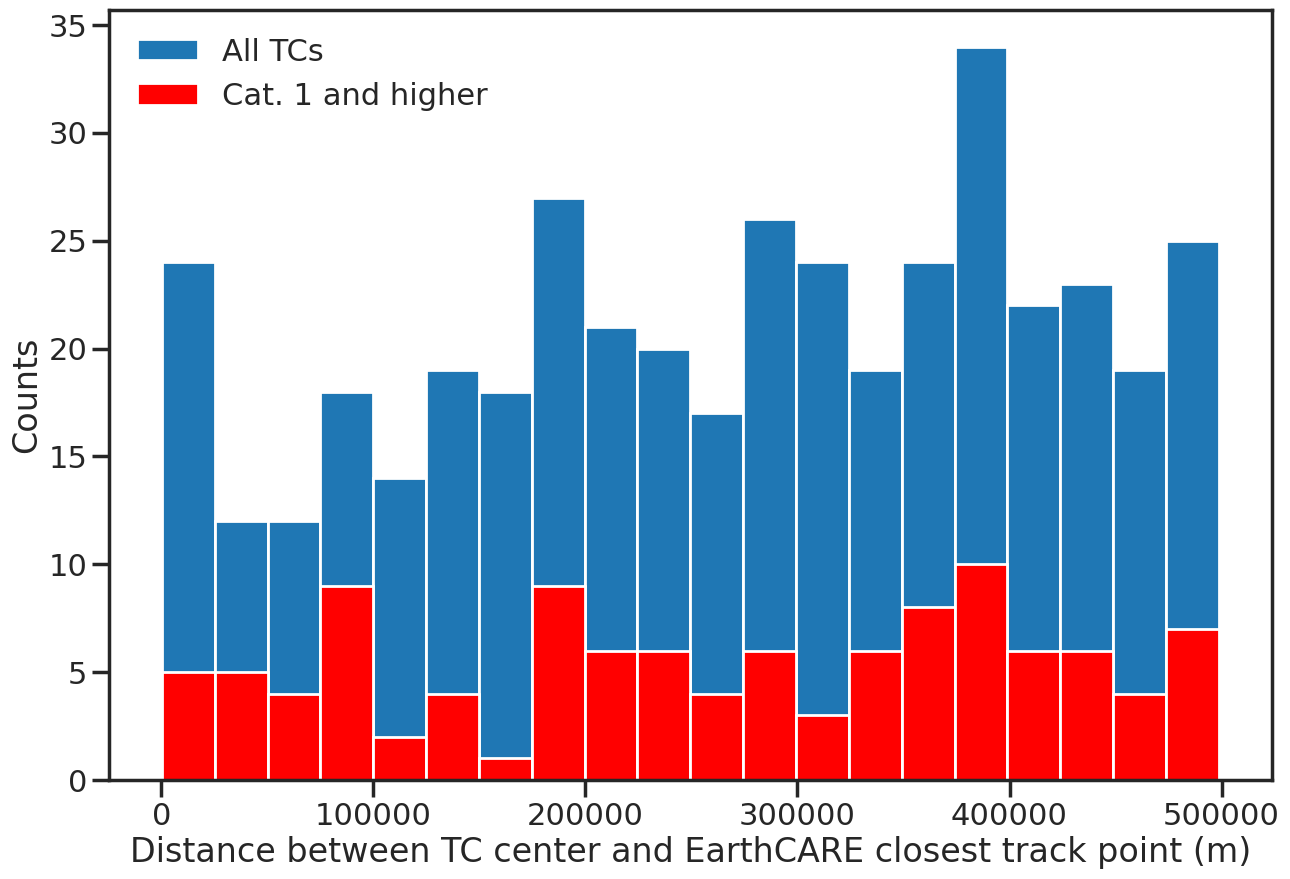

In [6]:
_, bins, _,  = plt.hist(MIN_DIS2CEN, bins=20, label='All TCs')
plt.hist(MIN_DIS2CEN_STRONG, bins=bins, color='red', label='Cat. 1 and higher')

plt.xlabel('Distance between TC center and EarthCARE closest track point (m)')
plt.ylabel('Counts')
plt.legend(frameon=False)

# plt.savefig(PTHS['sav_dir'] + 'Histogram_EarthCARE_data_on_TCs.png', bbox_inches='tight')

In [8]:
# p      = '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc'
# leslie = xr.open_dataset(p)
# print(leslie.closest_distance_to_track_center_ibt.values)

### Plotting the overpasses that are close to a TC center

  0%|          | 0/418 [00:00<?, ?it/s]

36.007999420166016
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/09/15/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc
30.5 123.39891100009389

2024-09-15T17:34:33.985041282
Vmax = 36.0 m/s
Rmax = 27.8 km 
Trimming by latitude


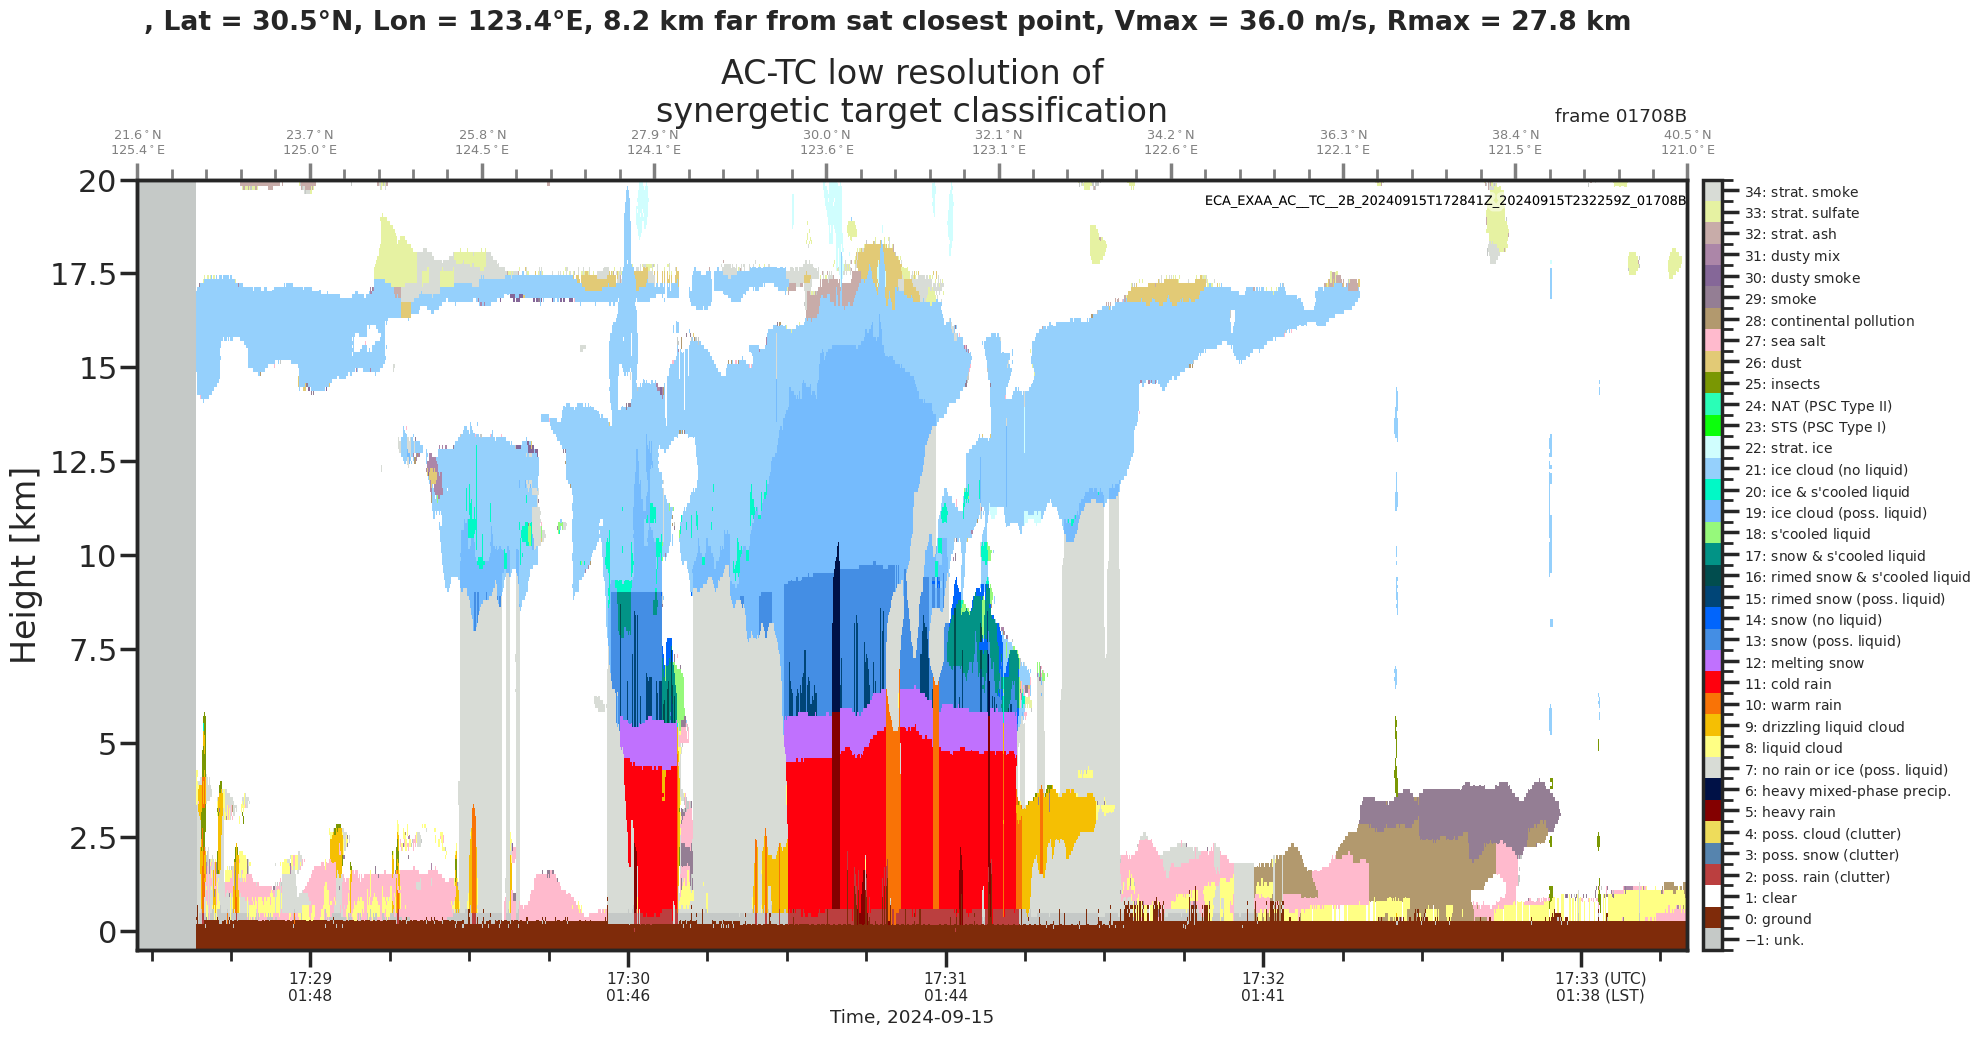

44.216323079685395
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/10/ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.nc
22.56809748665187 -49.57238918366803
AL132024
2024-10-10T05:02:34.500543145
Vmax = 44.2 m/s
Rmax = 18.5 km 
Trimming by latitude


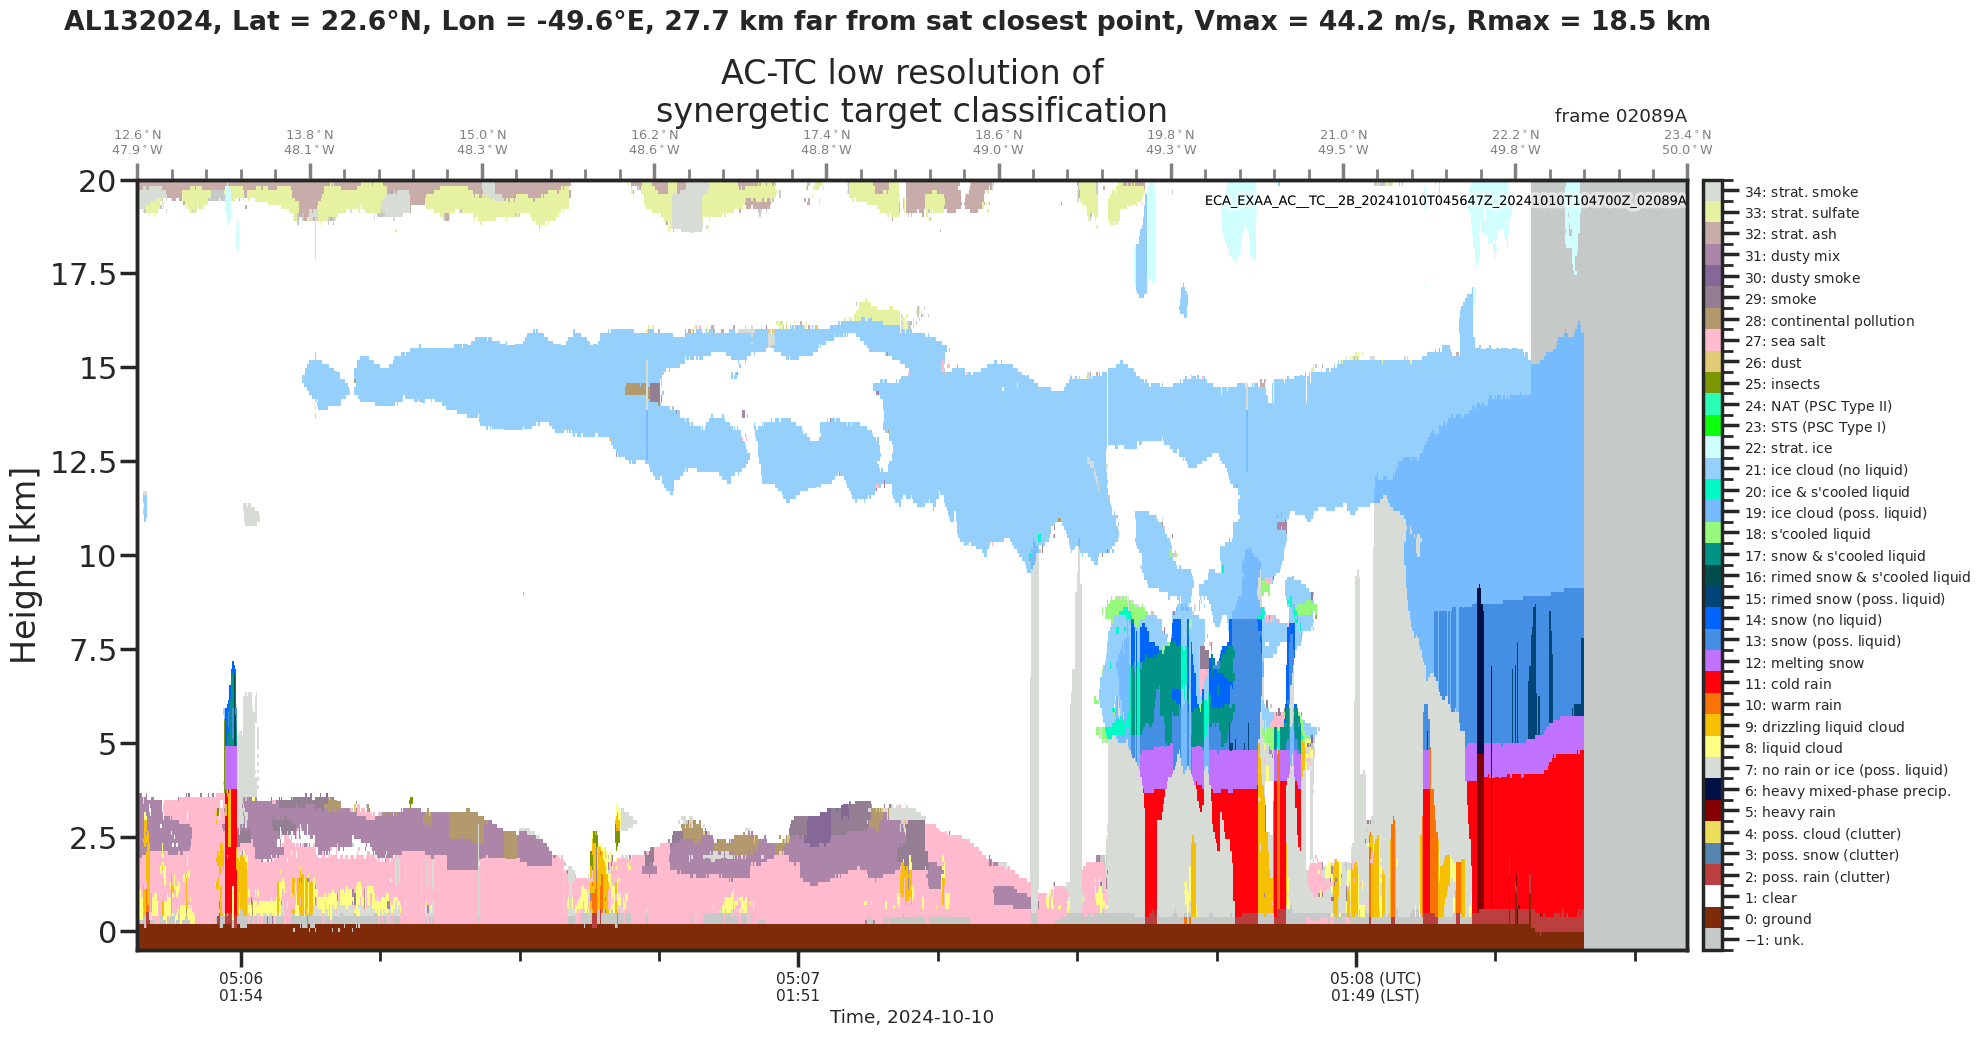

44.116146152417066
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/10/10/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc
22.574589011762736 -49.5983552841115
AL132024
2024-10-10T05:14:15.582580703
Vmax = 44.1 m/s
Rmax = 18.5 km 
Trimming by latitude


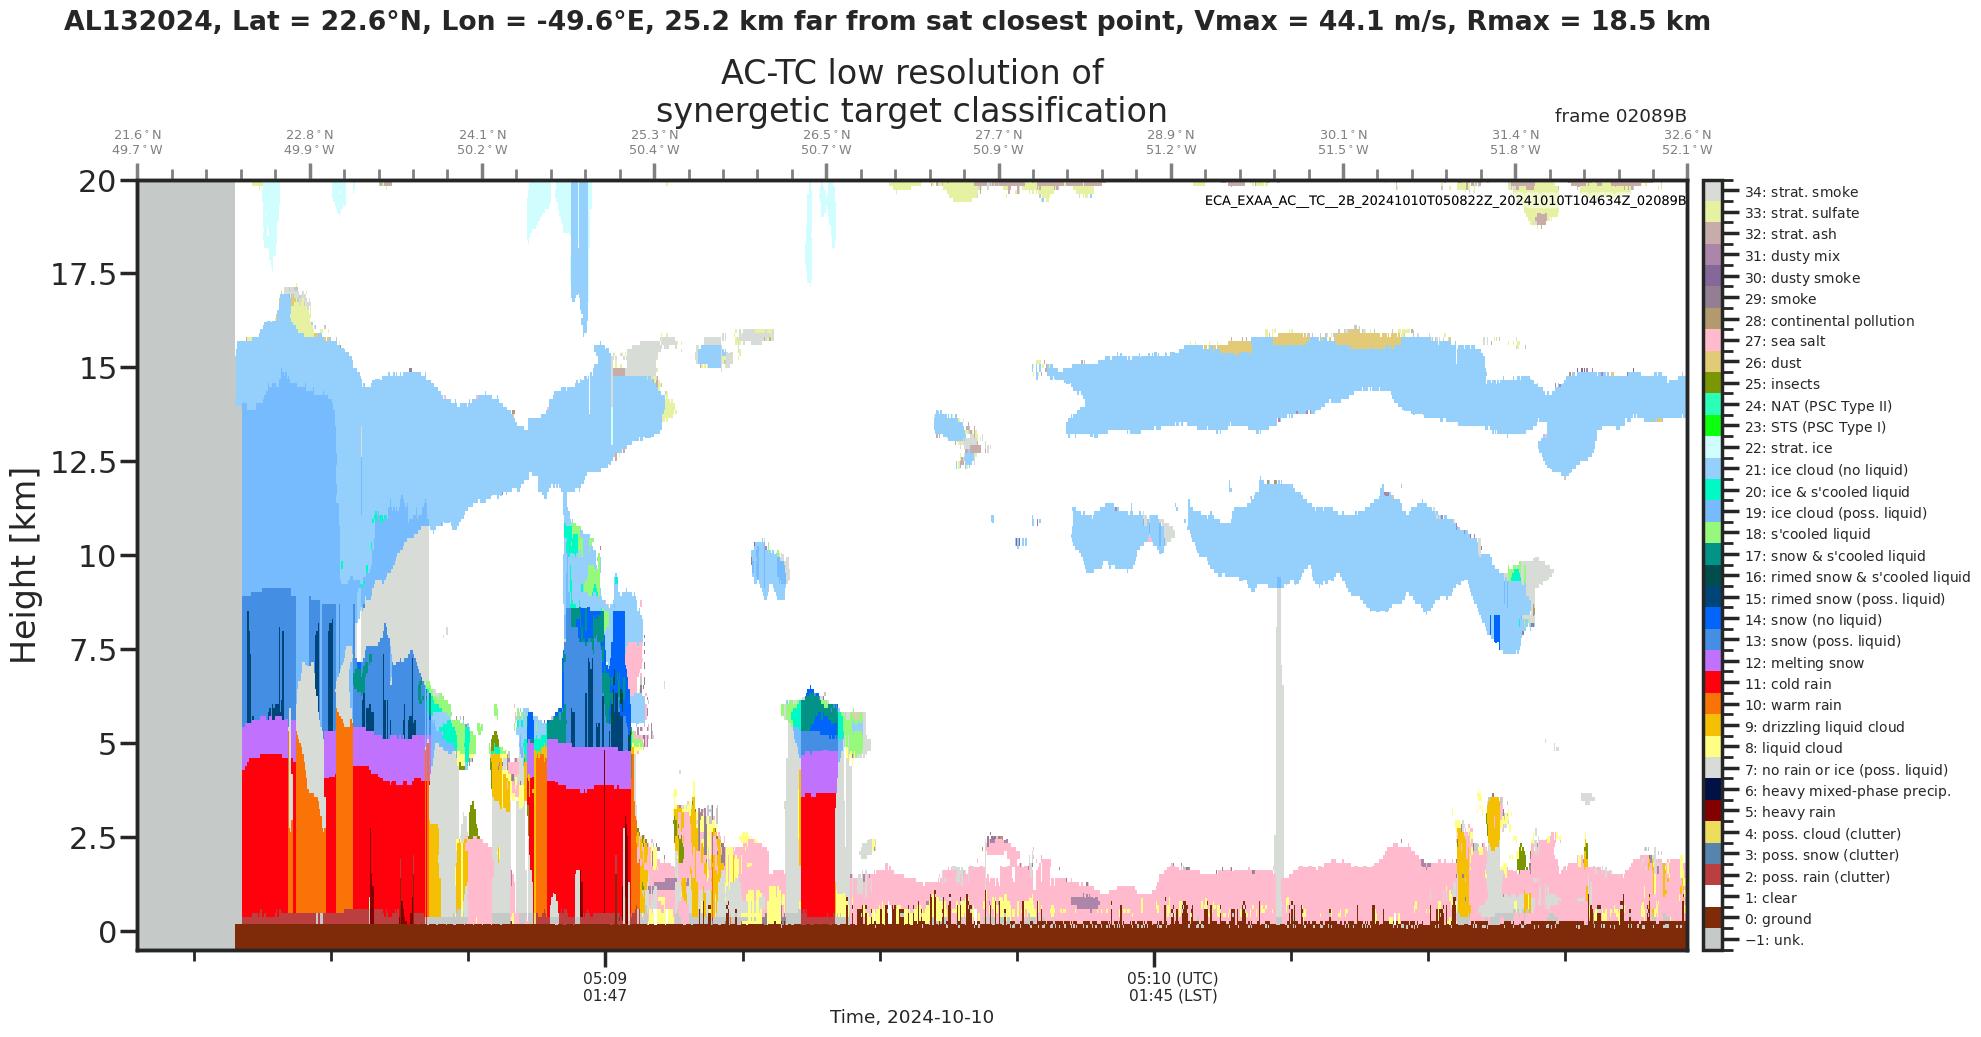

37.978406425755104
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/13/ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.nc
15.574574186827641 126.55085222762888

2024-11-13T05:44:44.657614780
Vmax = 38.0 m/s
Rmax = 31.5 km 
Trimming by latitude


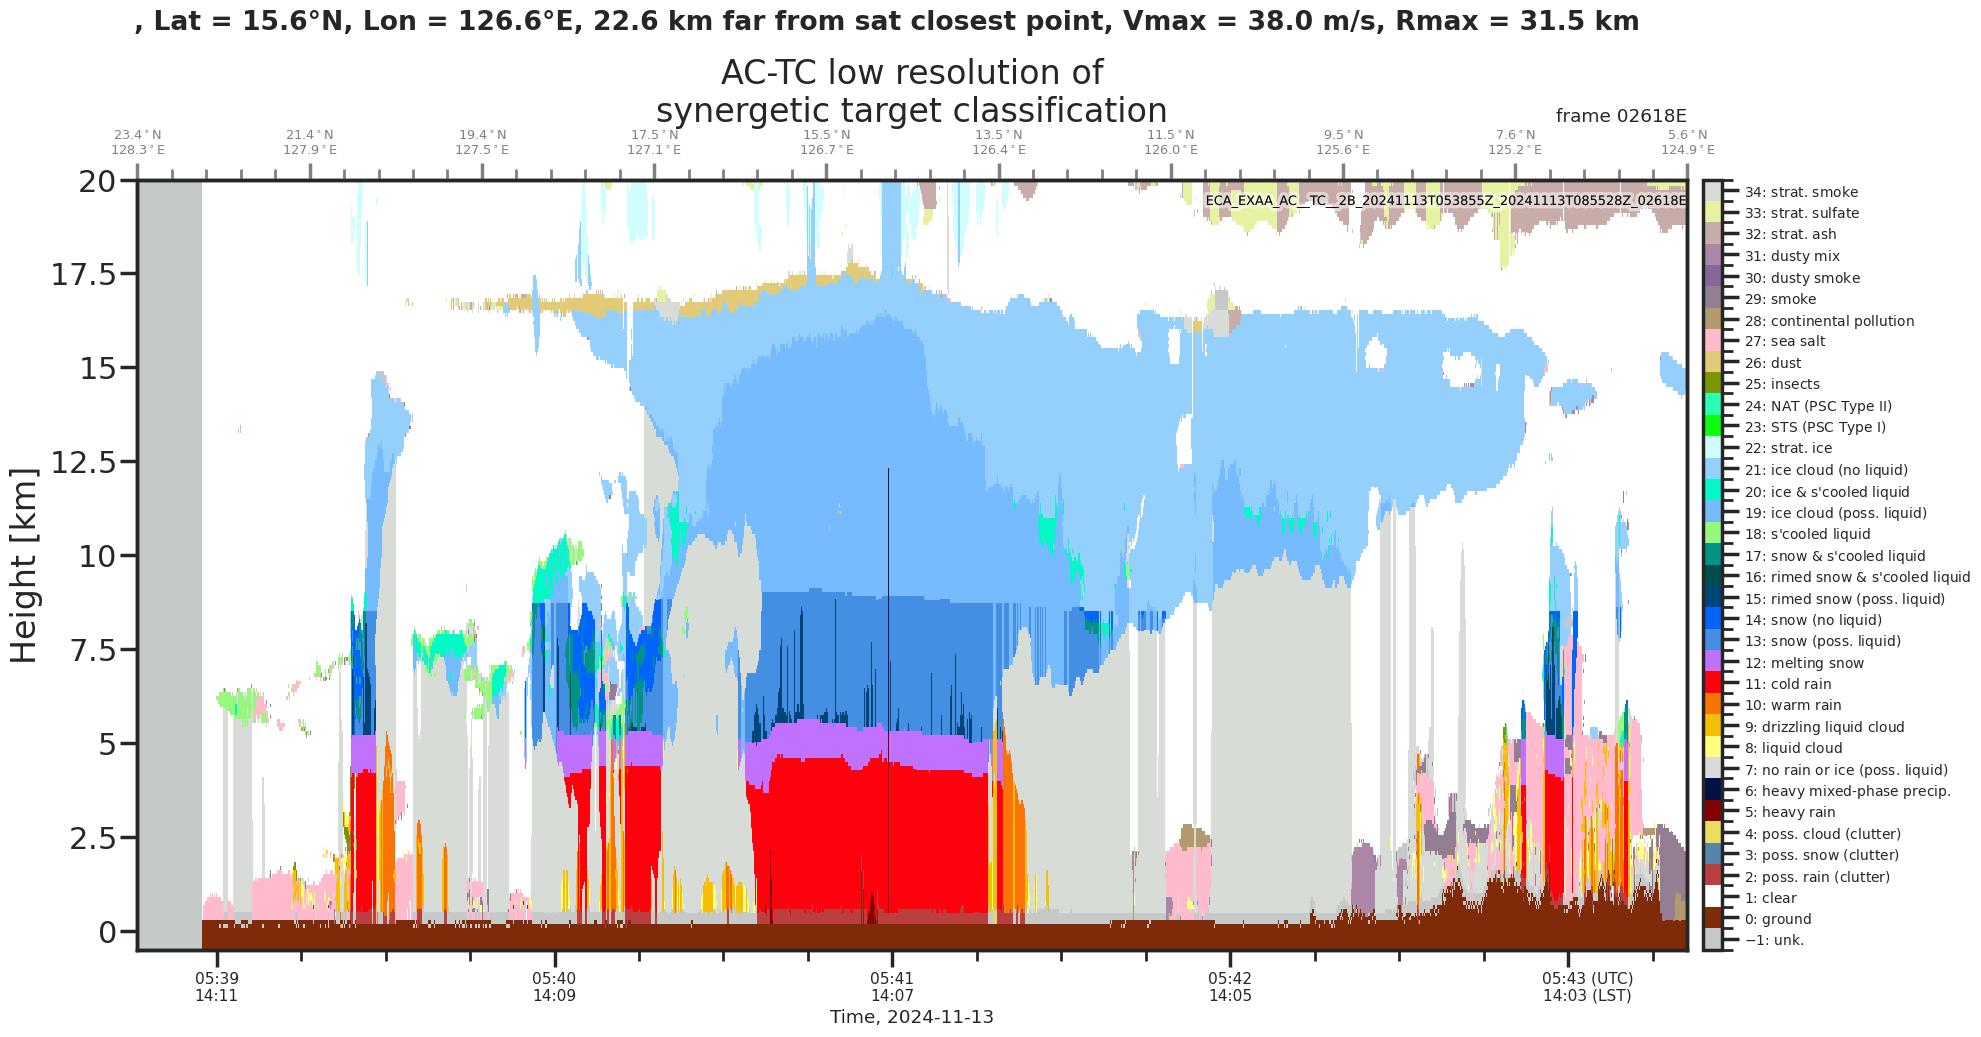

54.23535507814613
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/17/ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.nc
-17.019572559972318 69.6804247615854
SH022025
2024-11-17T21:35:13.828453331
Vmax = 54.2 m/s
Rmax = 22.2 km 
Trimming by latitude


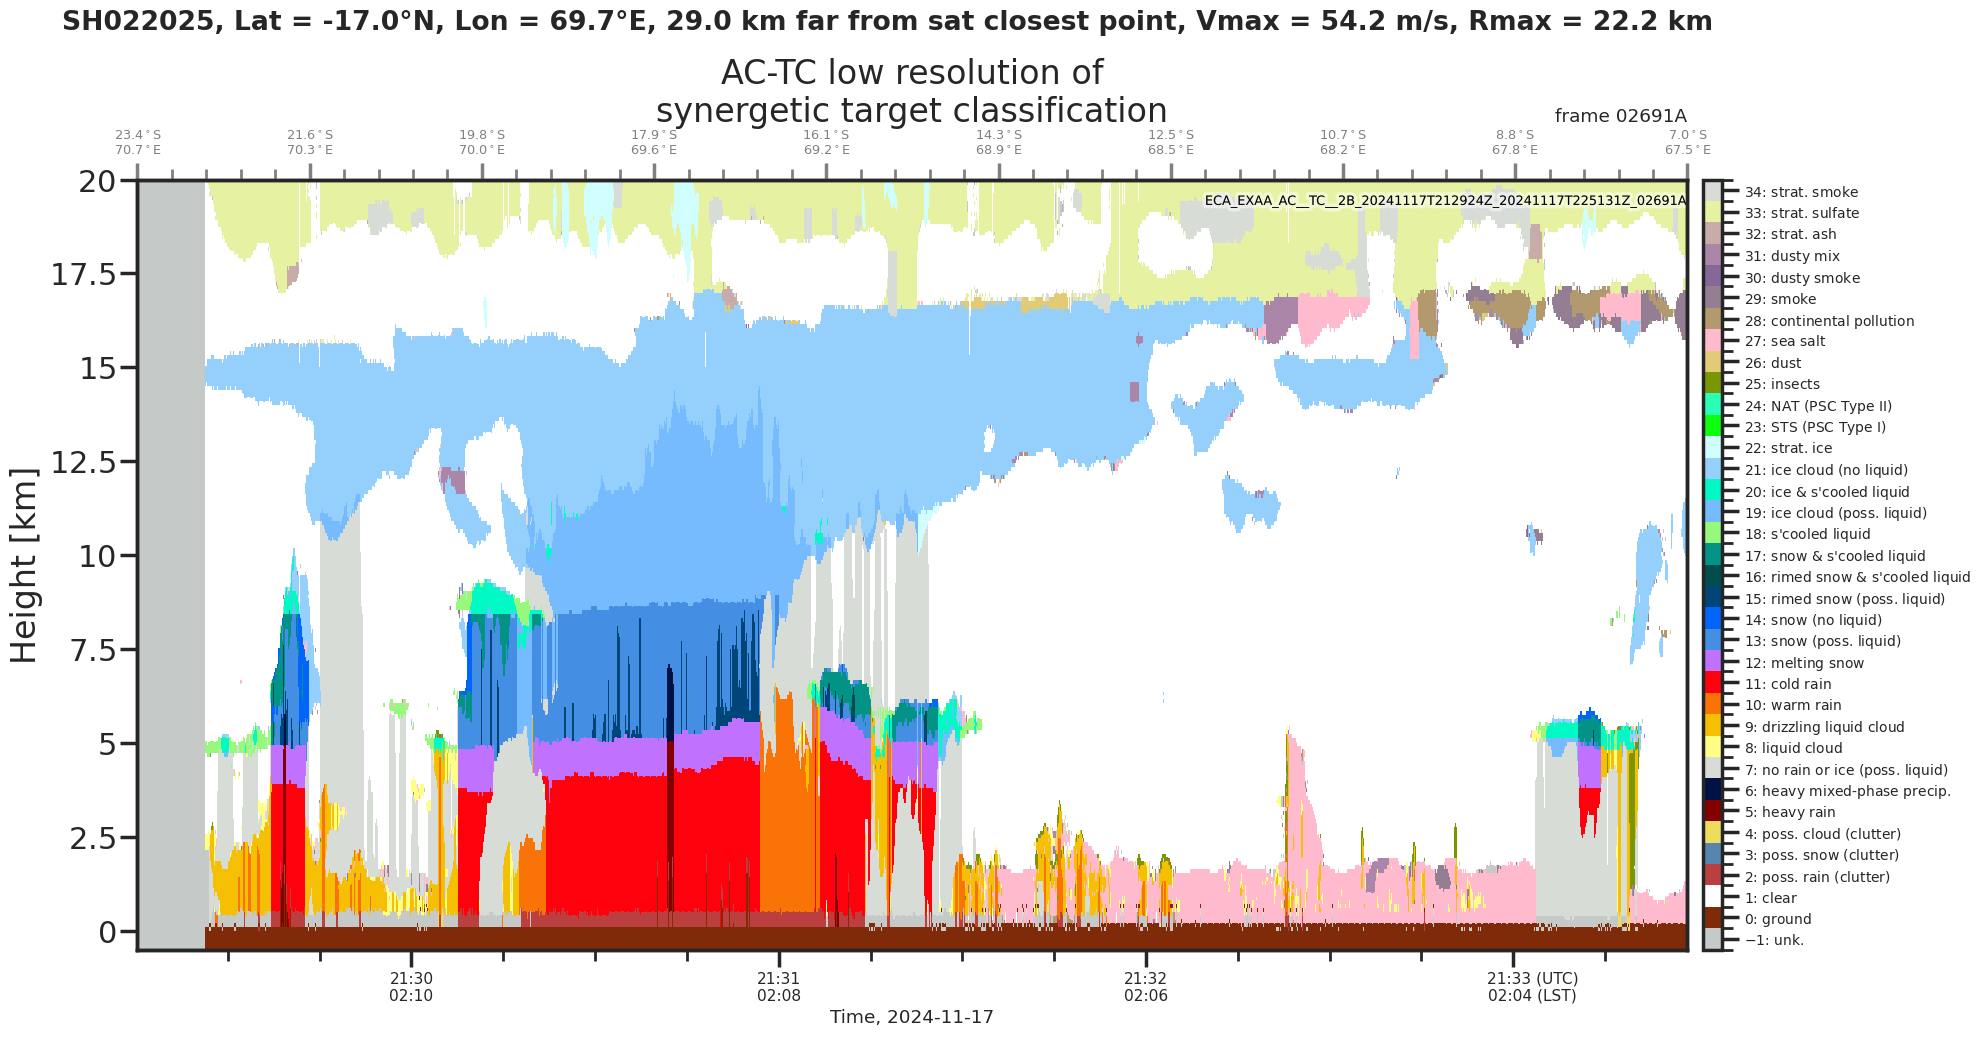

45.648574080668325
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2024/11/18/ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.nc
-17.5 69.18965286470745
SH022025
2024-11-18T09:09:18.589074204
Vmax = 45.6 m/s
Rmax = 28.0 km 
Trimming by latitude


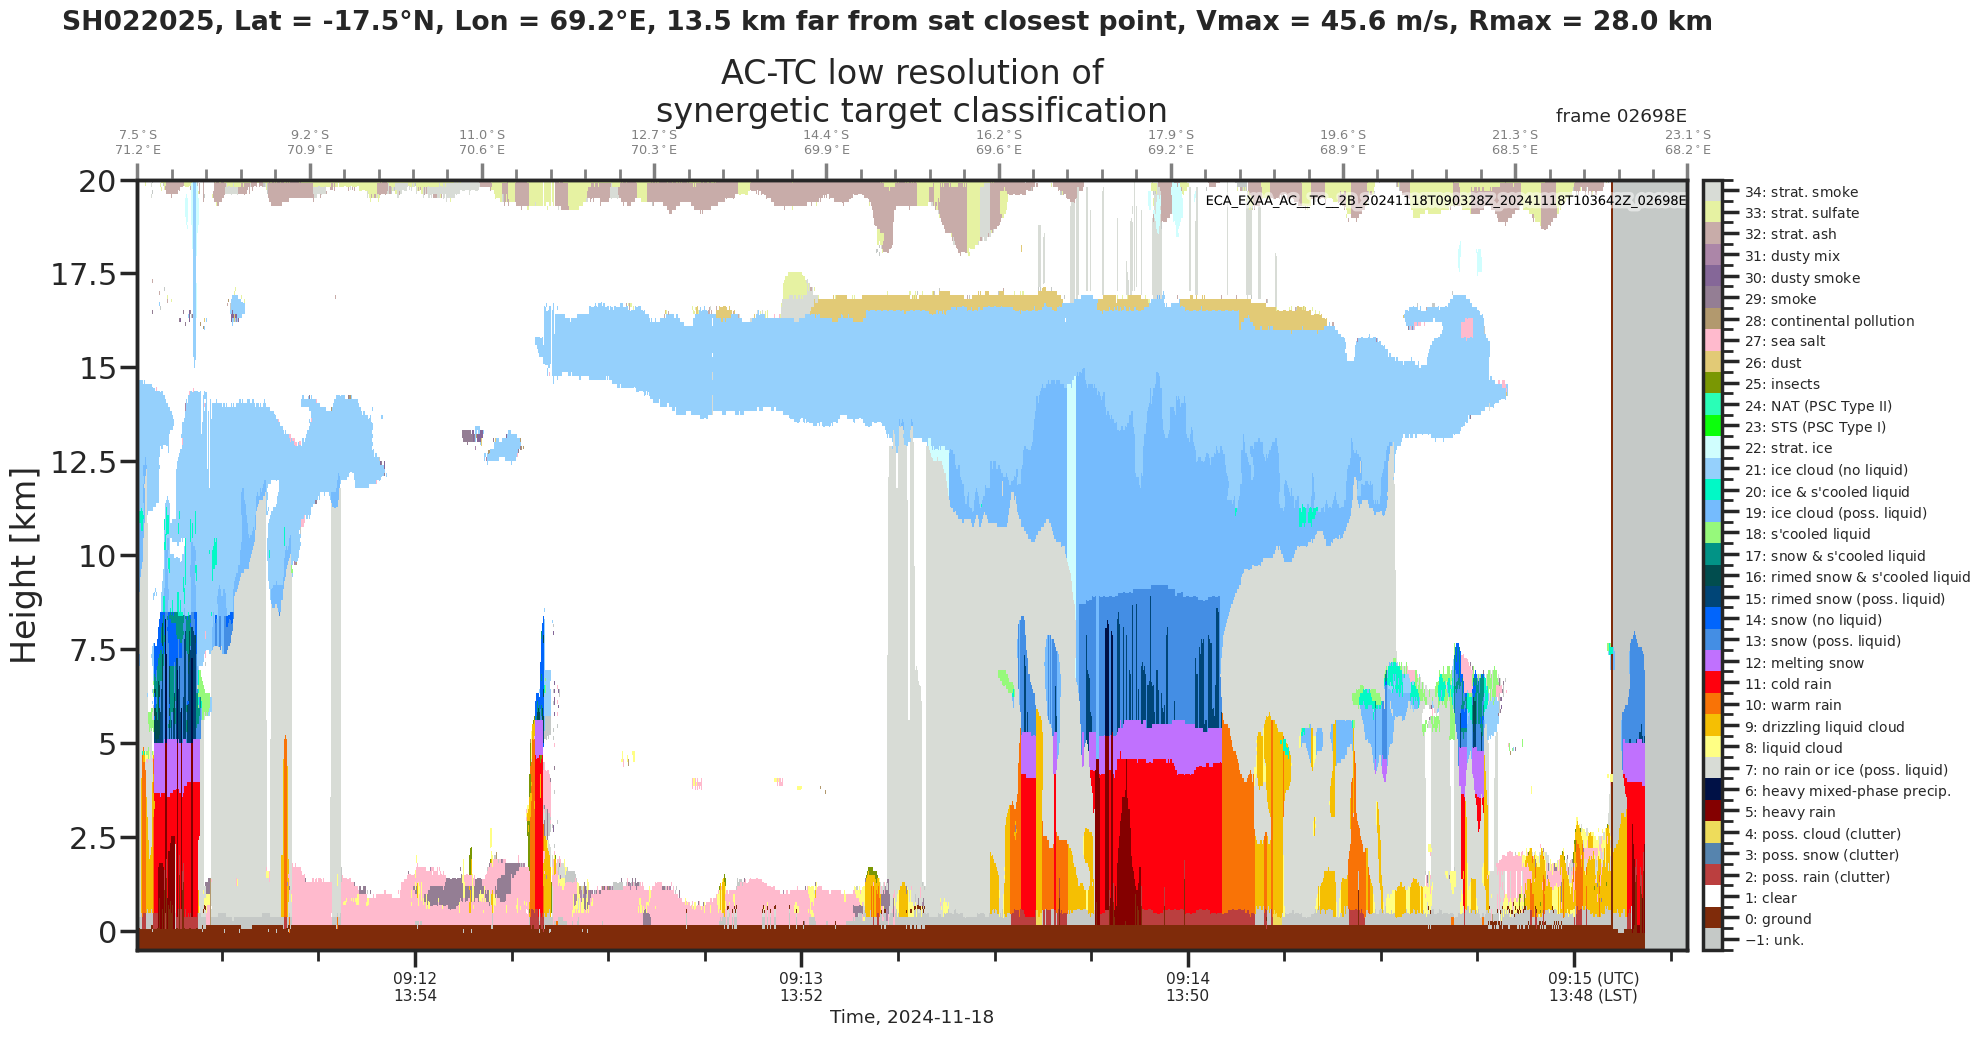

65.84320068359375
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AA/2025/02/07/ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.nc
-19.88542108523836 77.78746870411847
SH132025
2025-02-07T08:33:45.524450557
Vmax = 65.8 m/s
Rmax = 18.5 km 
Trimming by latitude


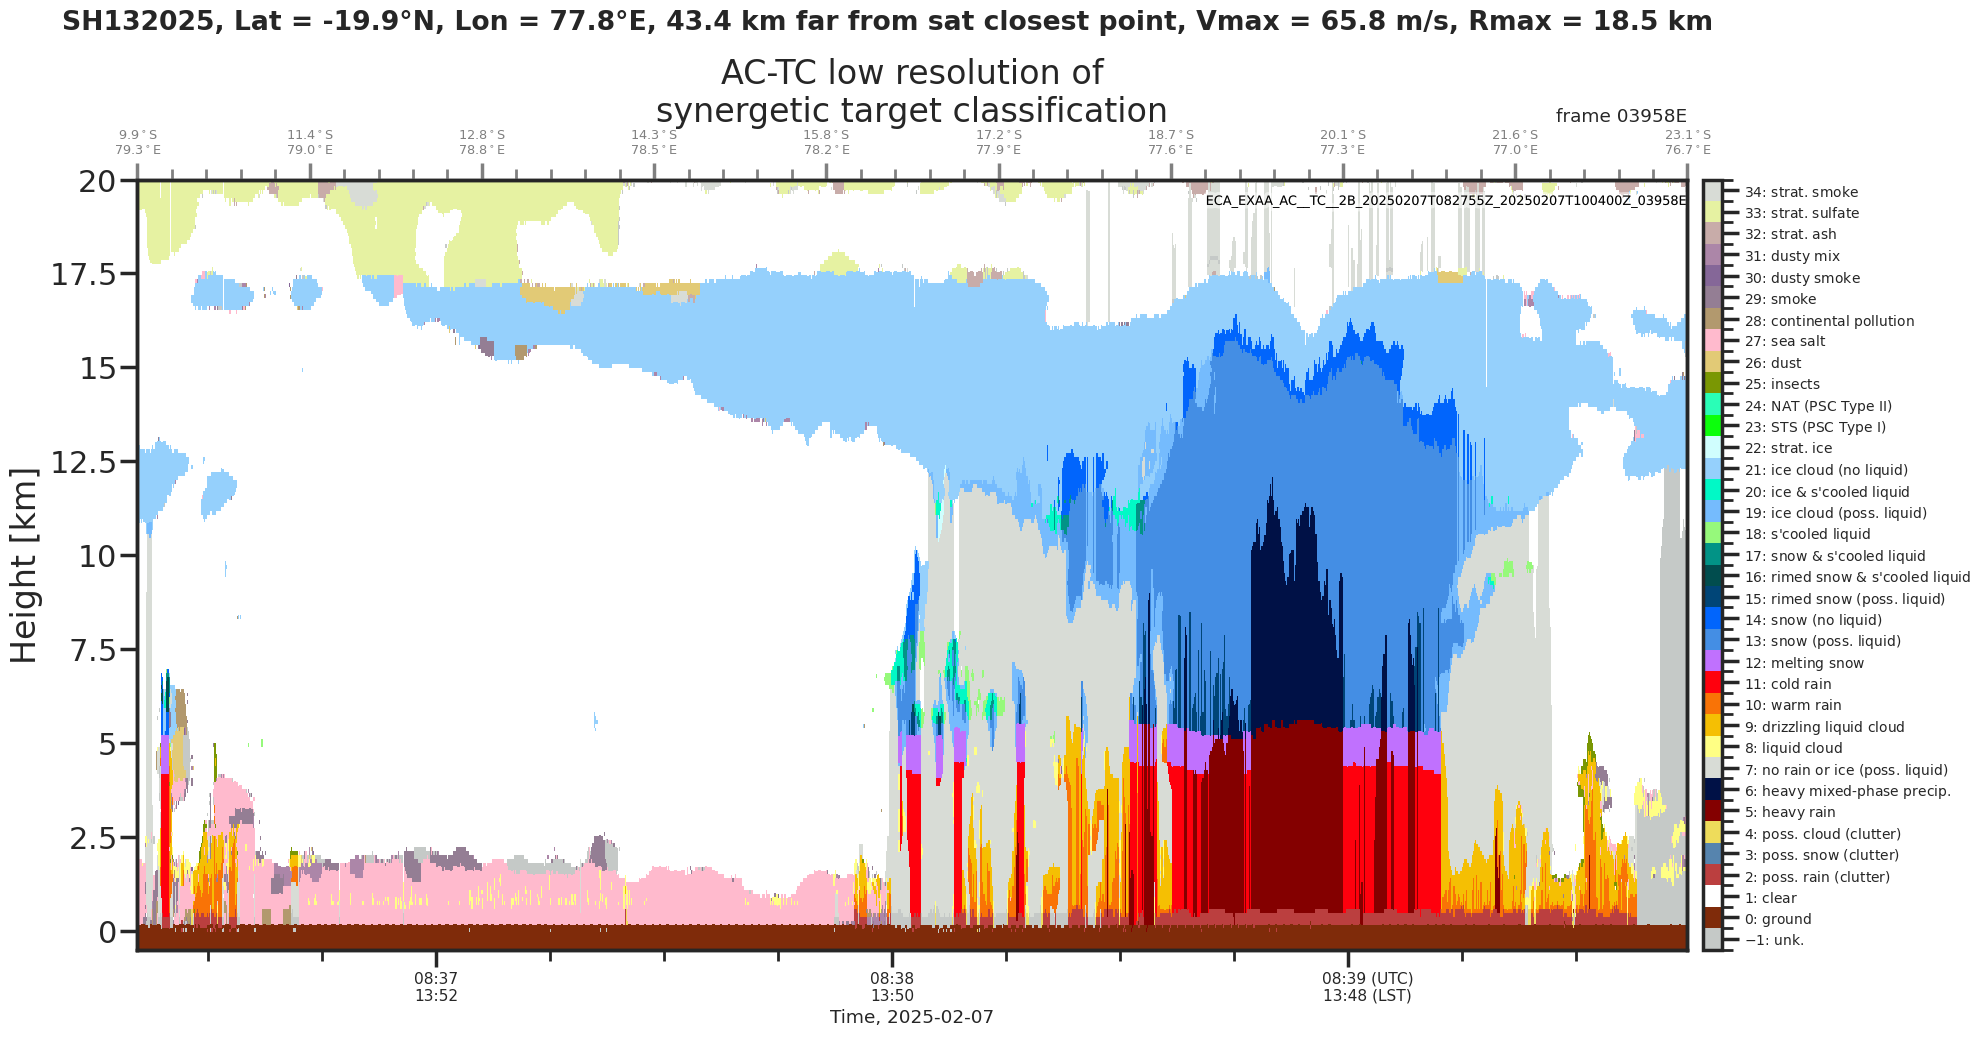

50.46752910521238
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/25/ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.nc
-22.118733019125372 102.19999694824219
SH202025
2025-02-25T06:53:25.794613605
Vmax = 50.5 m/s
Rmax = 18.5 km 
Trimming by latitude


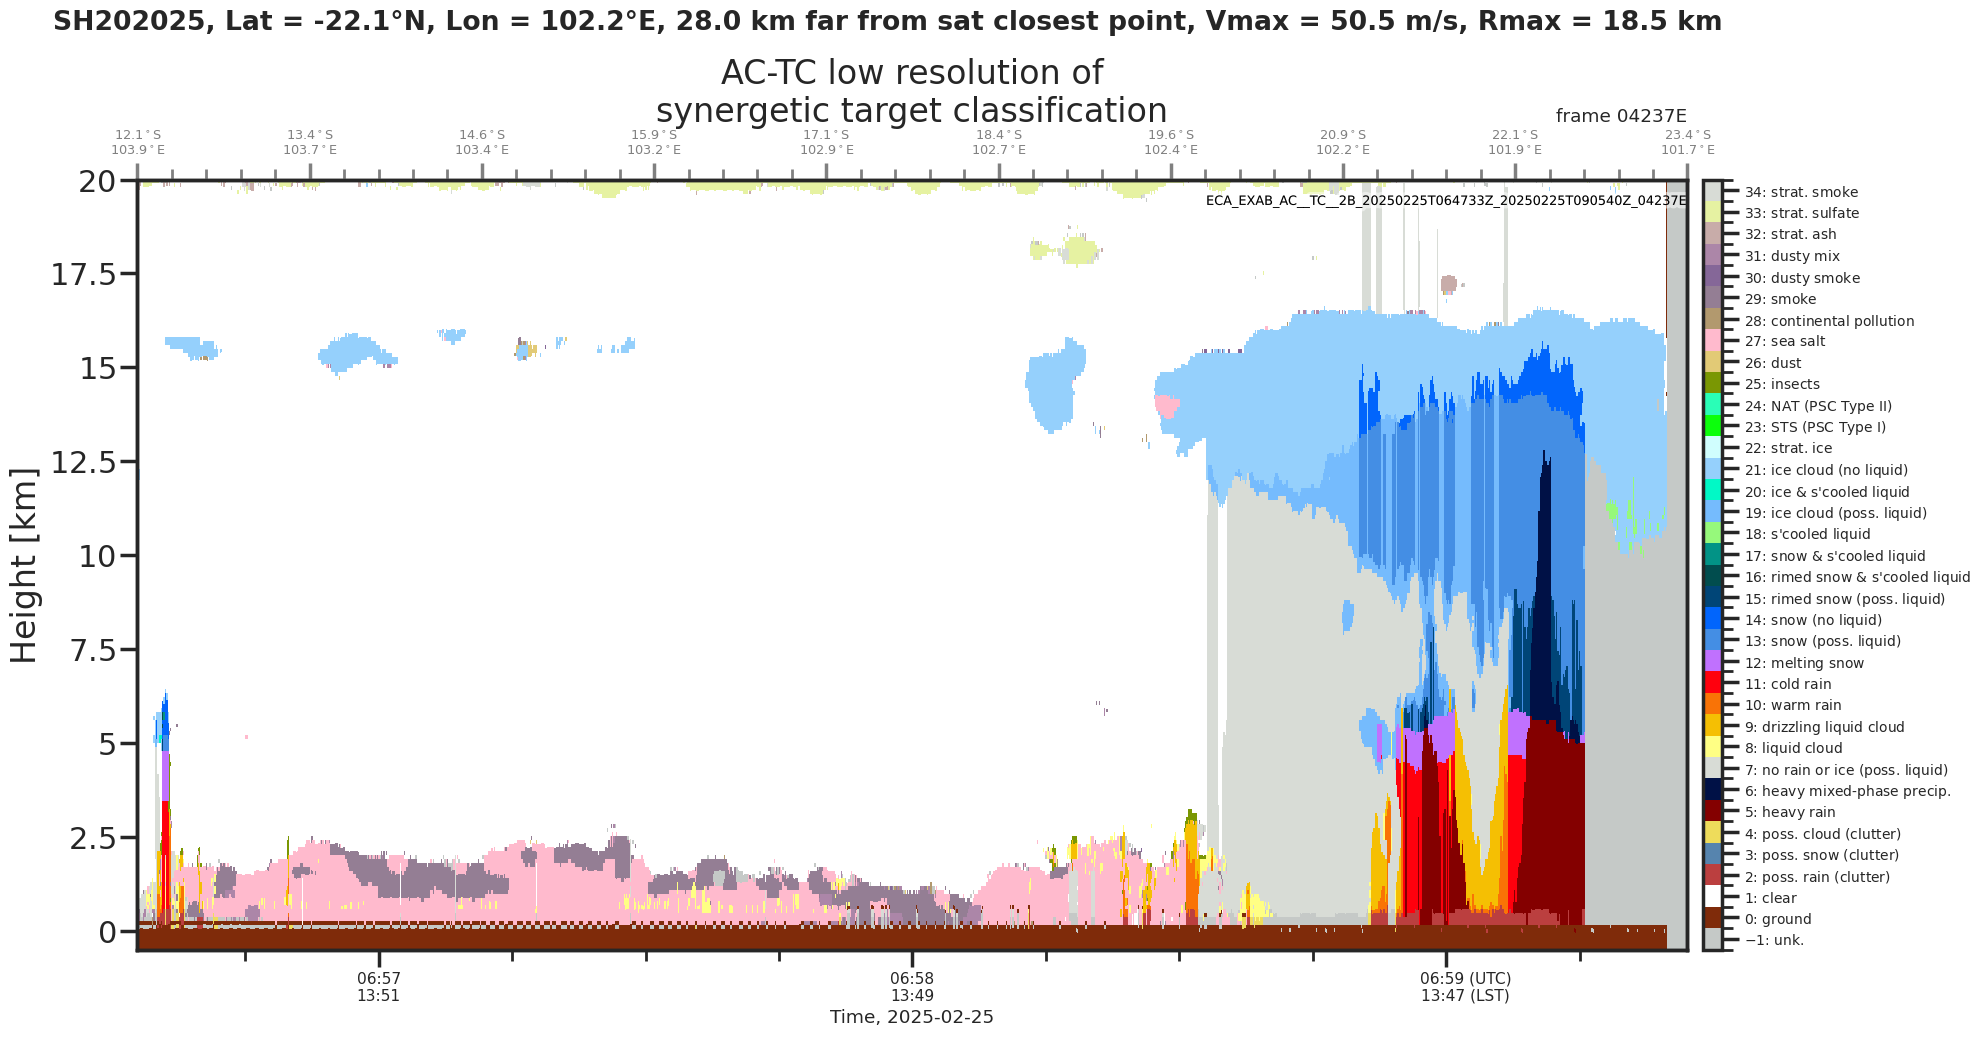

50.36719935053058
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/25/ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.nc
-22.144738608797486 102.19999694824219
SH202025
2025-02-25T07:05:07.946204376
Vmax = 50.4 m/s
Rmax = 18.5 km 
Trimming by latitude


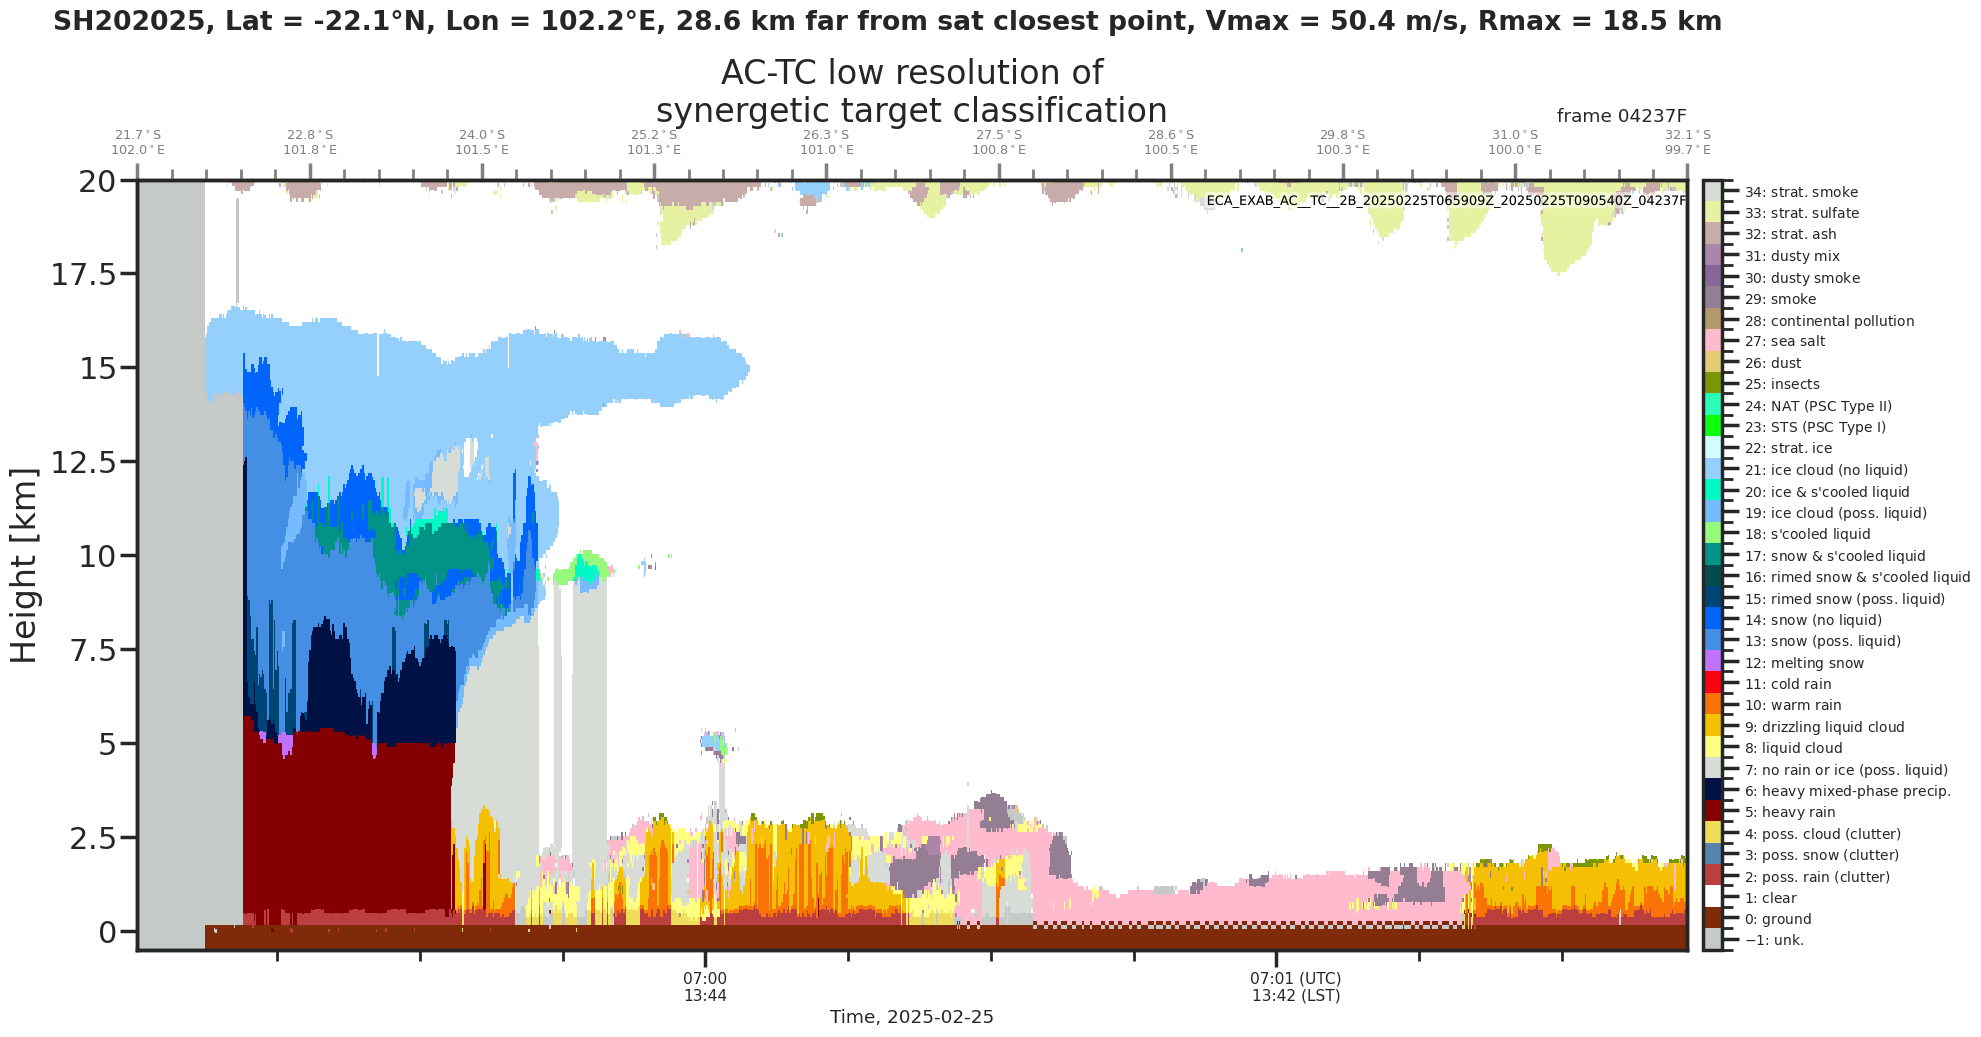

54.012001037597656
/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/AB/2025/02/28/ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.h5
/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.nc
-20.78707009437541 155.60000610351562
SH182025
2025-02-28T15:52:14.503943086
Vmax = 54.0 m/s
Rmax = 9.3 km 
Trimming by latitude


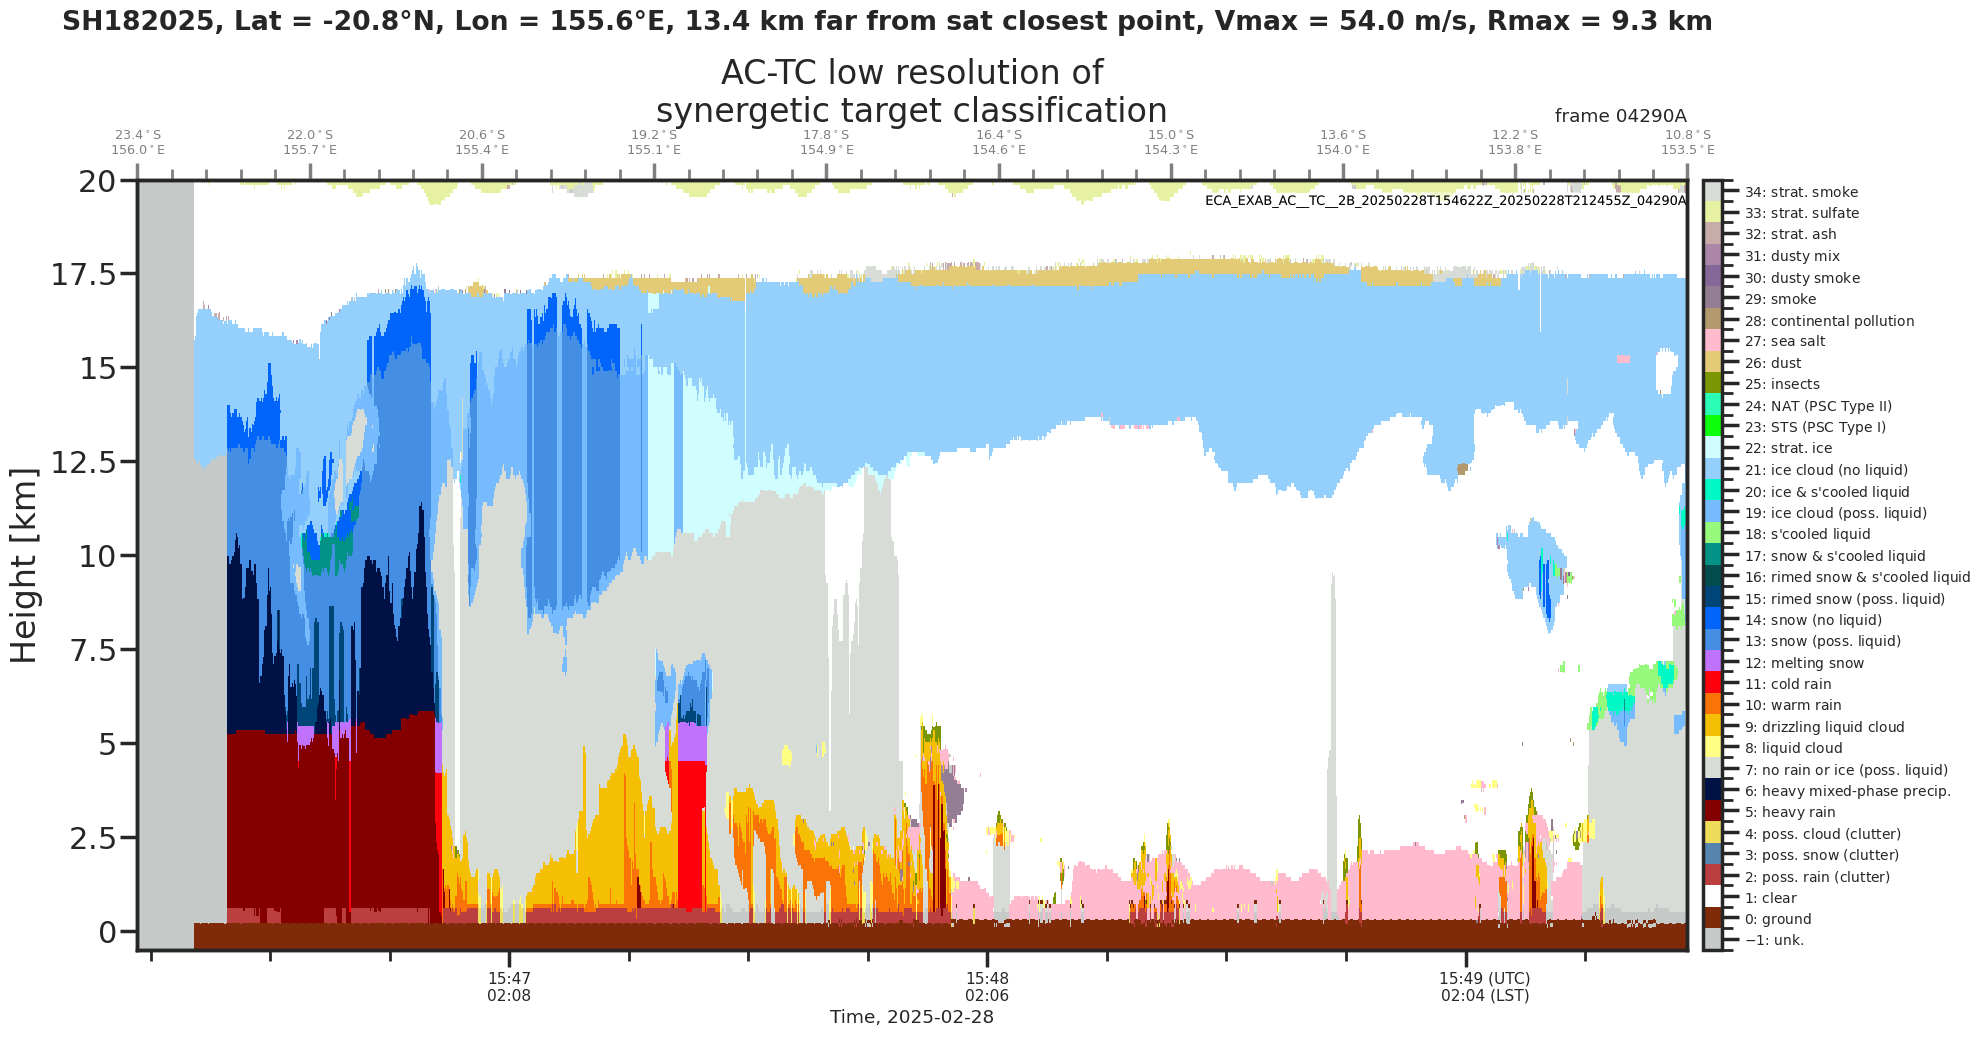

In [12]:
list_of_files  = []
list_of_frames = []

for file in tqdm(all_data):
    ds = xr.open_dataset(file)

    if (ds.vmx_ibt >= 33) & (ds.closest_distance_to_track_center_ibt <= 50000):
        list_of_frames.append(os.path.basename(file).split('.')[0].split('_')[-1])
        list_of_files.append(os.path.basename(file))
        
        # Display
        print(ds.vmx_ibt.values)
        print(ds.file.item())
        print(file)
        print(float(ds.lat_ibt), float(ds.lon_ibt))
        print(ds.atcf_id_ibt.item())
        print(ds.time.mean().data)
        print('Vmax = {:.1f} m/s'.format(ds.vmx_ibt))
        print('Rmax = {:.1f} km '.format(ds.rmx_ibt / 1000))

        # Latitudes are not necessarily ordererd from South to North
        # This may cause a trimming error when choosing lat_boundaries
        dx = 10
        if ds.latitude[1] - ds.latitude[0] > 0: # satellite goes from South to North
            lat_boundaries = [float(ds.lat_ibt) - dx, float(ds.lat_ibt) + dx]
        else:
            lat_boundaries = [float(ds.lat_ibt) + dx, float(ds.lat_ibt) - dx]

        # Load
        ACTC = ecio.load_ACTC(
            ds.file.item(),
            trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
        )

        # Plot
        fig, ax  = plt.subplots(figsize=(20, 10))
        title    = '{}, Lat = {:.1f}°N, Lon = {:.1f}°E, {:.1f} km far from sat closest point, Vmax = {:.1f} m/s, Rmax = {:.1f} km'.format(ds.atcf_id_ibt.item(), ds.lat_ibt, ds.lon_ibt, ds.closest_distance_to_track_center_ibt / 1000, ds.vmx_ibt, ds.rmx_ibt / 1000)
        fig.suptitle(title, y=1.05, weight='bold')
        ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

        # Save
        # plt.savefig(PTHS['sav_dir'] + os.path.basename(file)[:-3] + '.png', bbox_inches='tight');plt.clf()
        plt.show()
        
    ds.close()

In [13]:
print(list_of_frames)
print(list_of_files)

['01708B', '02089A', '02089B', '02618E', '02691A', '02698E', '03958E', '04237E', '04237F', '04290A']
['ECA_EXAA_AC__TC__2B_20240915T172841Z_20240915T232259Z_01708B.nc', 'ECA_EXAA_AC__TC__2B_20241010T045647Z_20241010T104700Z_02089A.nc', 'ECA_EXAA_AC__TC__2B_20241010T050822Z_20241010T104634Z_02089B.nc', 'ECA_EXAA_AC__TC__2B_20241113T053855Z_20241113T085528Z_02618E.nc', 'ECA_EXAA_AC__TC__2B_20241117T212924Z_20241117T225131Z_02691A.nc', 'ECA_EXAA_AC__TC__2B_20241118T090328Z_20241118T103642Z_02698E.nc', 'ECA_EXAA_AC__TC__2B_20250207T082755Z_20250207T100400Z_03958E.nc', 'ECA_EXAB_AC__TC__2B_20250225T064733Z_20250225T090540Z_04237E.nc', 'ECA_EXAB_AC__TC__2B_20250225T065909Z_20250225T090540Z_04237F.nc', 'ECA_EXAB_AC__TC__2B_20250228T154622Z_20250228T212455Z_04290A.nc']


### Plotting all overpasses in a TC reference frame

In [5]:
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

  0%|          | 0/418 [00:00<?, ?it/s]

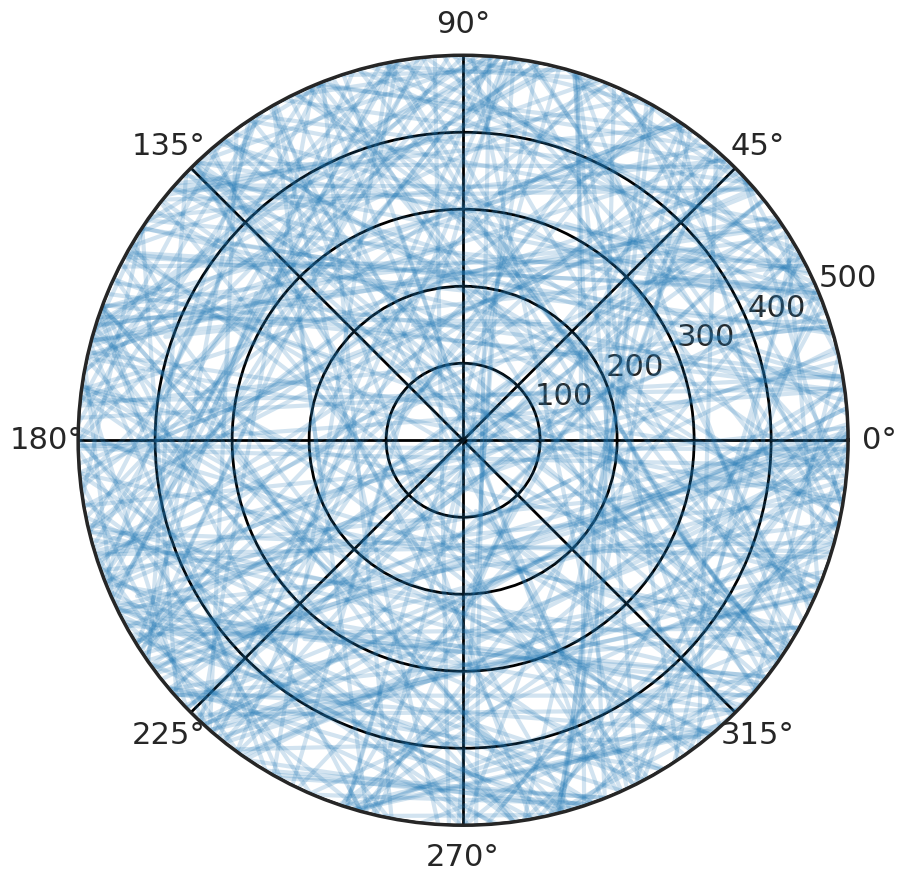

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)
    
    # Compute polar coordinates of EarthCARE
    # We also rotate the storm
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(ds.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Plot
    ax.plot(np.deg2rad(ds.th), ds.r / 1000, c='tab:blue', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(500)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

  0%|          | 0/418 [00:00<?, ?it/s]

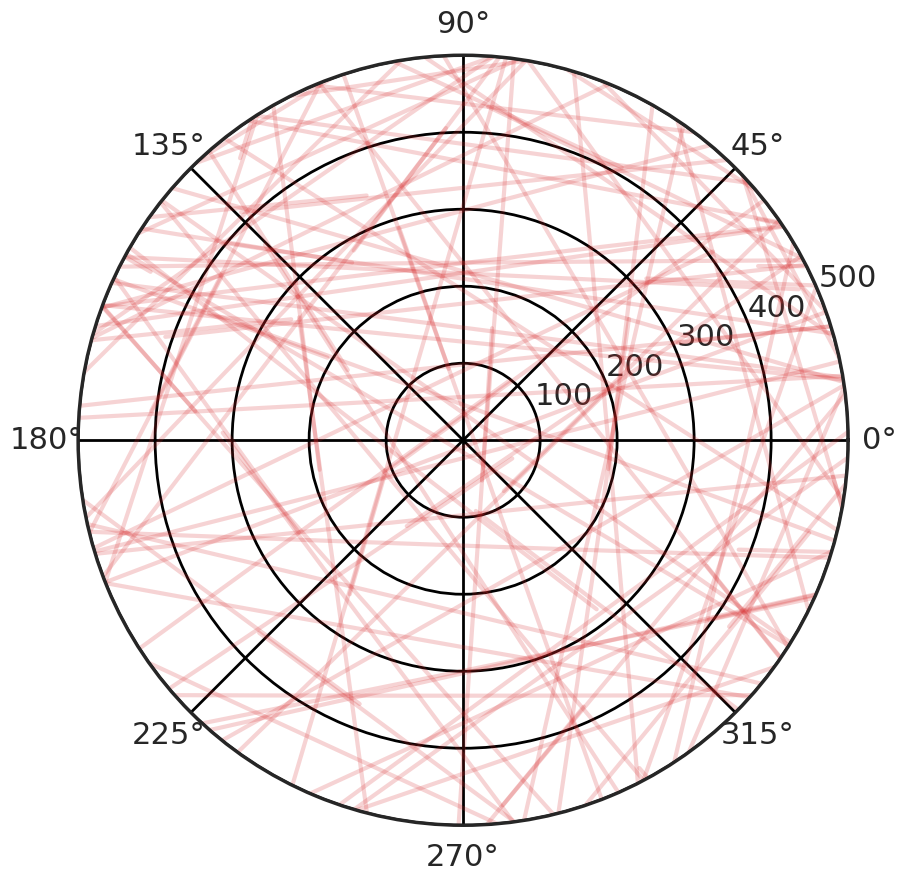

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)

    if ds.vmx_ibt >= 33:
        # Compute polar coordinates of EarthCARE
        # We also rotate the storm
        geod_wgs84        = CRS("epsg:4326").get_geod()
        forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
        forward_az        = forward_az - float(ds.storm_dir_ibt)
        th                = get_polar_theta(forward_az) # r is dr
        ds['r']           = xr.DataArray(data=dr, dims=['ray'])
        ds['th']          = xr.DataArray(data=th, dims=['ray'])
    
        # Plot
        ax.plot(np.deg2rad(ds.th), ds.r / 1000, c='tab:red', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(500)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

  0%|          | 0/418 [00:00<?, ?it/s]

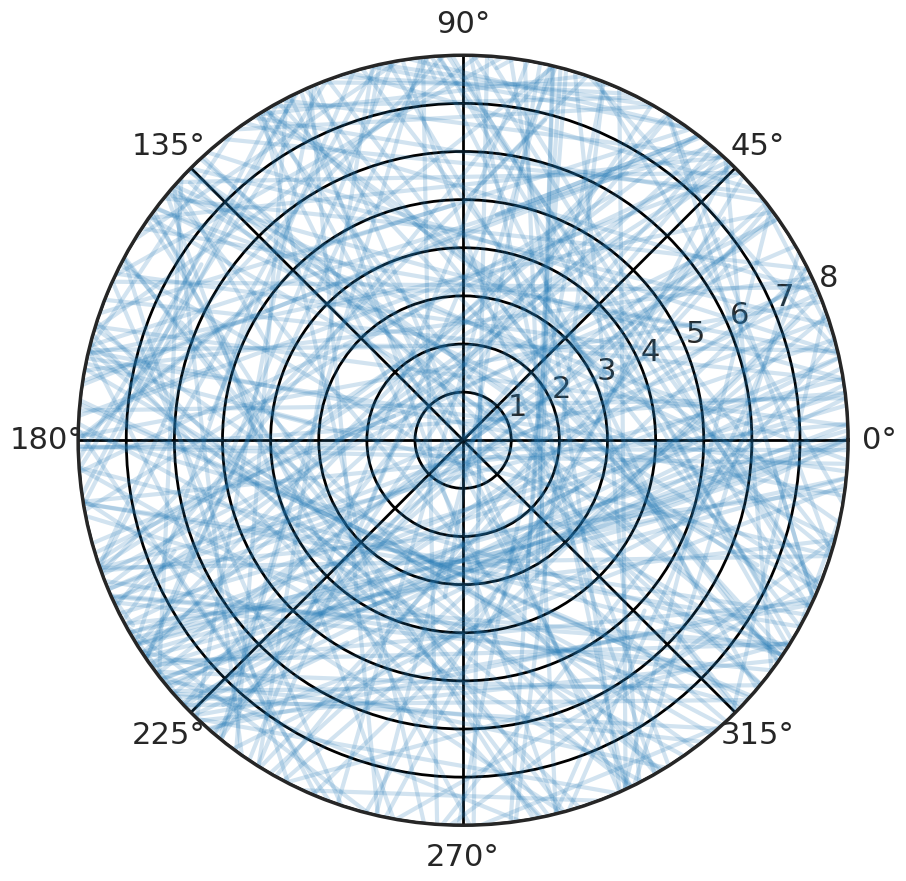

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)
    
    # Compute polar coordinates of EarthCARE
    # We also rotate the storm
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
    forward_az        = forward_az - float(ds.storm_dir_ibt)
    th                = get_polar_theta(forward_az) # r is dr
    ds['r']           = xr.DataArray(data=dr, dims=['ray'])
    ds['th']          = xr.DataArray(data=th, dims=['ray'])

    # Plot
    ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:blue', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(8)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)    # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

  0%|          | 0/418 [00:00<?, ?it/s]

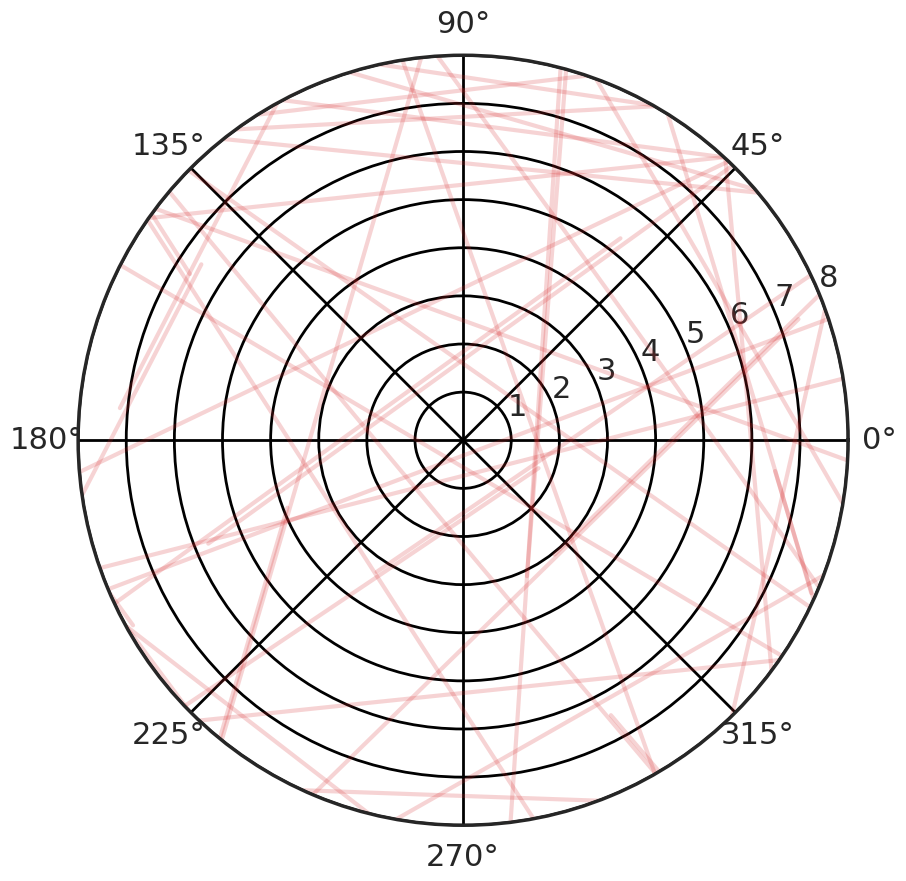

In [9]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for file in tqdm(all_data):
    # Open file
    ds = xr.open_dataset(file)

    if ds.vmx_ibt >= 33:
        # Compute polar coordinates of EarthCARE
        # We also rotate the storm
        geod_wgs84        = CRS("epsg:4326").get_geod()
        forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
        forward_az        = forward_az - float(ds.storm_dir_ibt)
        th                = get_polar_theta(forward_az) # r is dr
        ds['r']           = xr.DataArray(data=dr, dims=['ray'])
        ds['th']          = xr.DataArray(data=th, dims=['ray'])
    
        # Plot
        ax.plot(np.deg2rad(ds.th), ds.r / ds.rmx_ibt, c='tab:red', alpha=0.2)

    # Close dataset
    ds.close()

ax.set_rmax(8)
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, color='k', linewidth=2)

In [7]:
# # Compute polar coordinates of EarthCARE
# # We also rotate the storm
# geod_wgs84        = CRS("epsg:4326").get_geod()
# forward_az, _, dr = geod_wgs84.inv(np.ones_like(ds.longitude) * float(ds.lon_ibt), np.ones_like(ds.latitude) * float(ds.lat_ibt), ds.longitude, ds.latitude)
# forward_az        = forward_az - float(ds.storm_dir_ibt)
# th                = get_polar_theta(forward_az) # r is dr

# ds['r']           = xr.DataArray(data=dr, dims=['ray'])
# ds['th']          = xr.DataArray(data=th, dims=['ray'])

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.plot(np.deg2rad(ds.th), ds.r / 1000)
# ax.set_rmax(500)
# # ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
# # ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

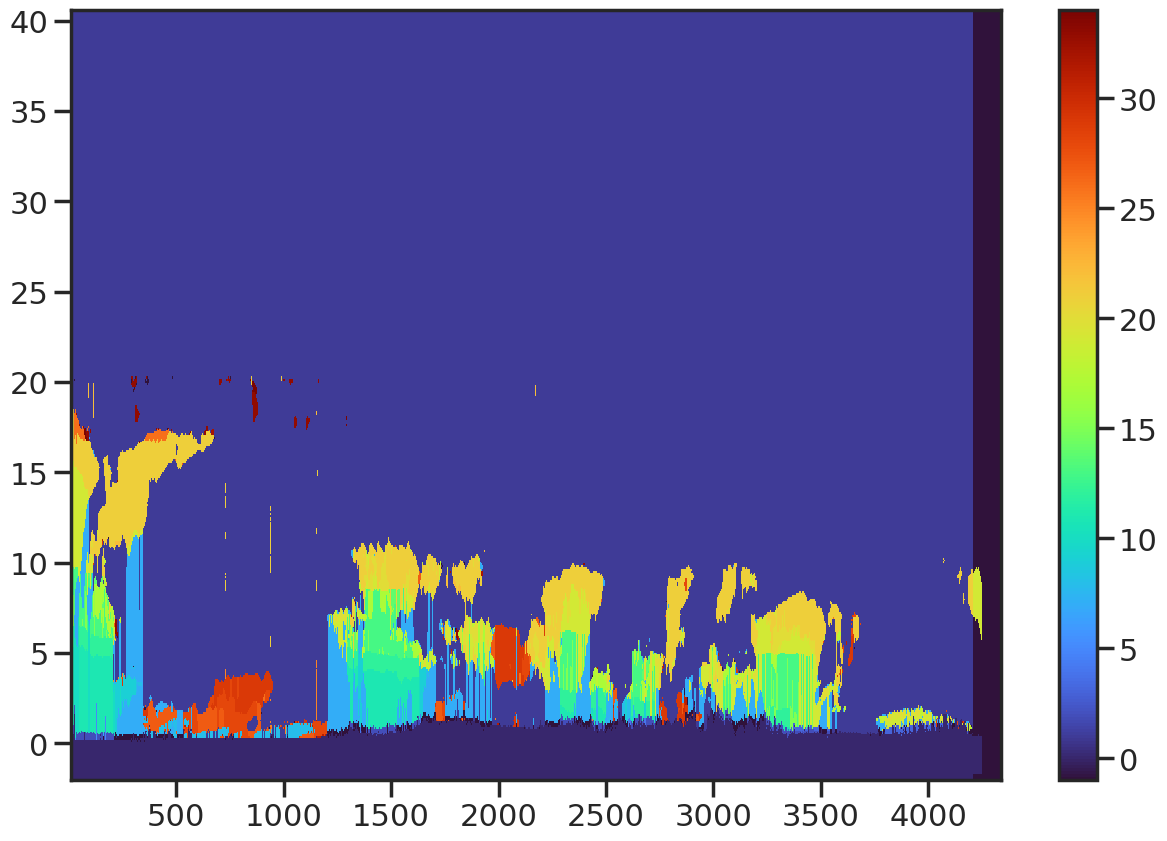

In [35]:
# Plot transect
RS = np.tile(ds.r, (len(ds.JSG_height), 1)).transpose()
plt.pcolor(RS / 1000, ds.height / 1000, ds.synergetic_target_classification, cmap='turbo')
plt.colorbar()

In [13]:
# p  = '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20250112T105253Z_20250112T123739Z_03555E.nc'
# ds = xr.open_dataset(p)

In [12]:
# # Display
# print(ds.vmx_ibt.values)
# print(ds.file.item())
# print(file)
# print(float(ds.lat_ibt), float(ds.lon_ibt))
# print(ds.atcf_id_ibt.item())
# print(ds.time.mean().data)
# print('Vmax = {:.1f} m/s'.format(ds.vmx_ibt))
# print('Rmax = {:.1f} km '.format(ds.rmx_ibt / 1000))

# # Latitudes are not necessarily ordererd from South to North
# # This may cause a trimming error when choosing lat_boundaries
# dx = 10
# if ds.latitude[1] - ds.latitude[0] > 0: # satellite goes from South to North
#     lat_boundaries = [float(ds.lat_ibt) - dx, float(ds.lat_ibt) + dx]
# else:
#     lat_boundaries = [float(ds.lat_ibt) + dx, float(ds.lat_ibt) - dx]

# # Load
# ACTC = ecio.load_ACTC(
#     ds.file.item(),
#     trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
# )

# # Plot
# fig, ax  = plt.subplots(figsize=(20, 10))
# title    = '{}, Lat = {:.1f}°N, Lon = {:.1f}°E, {:.1f} km far from sat closest point, Vmax = {:.1f} m/s, Rmax = {:.1f} km'.format(ds.atcf_id_ibt.item(), ds.lat_ibt, ds.lon_ibt, ds.closest_distance_to_track_center_ibt / 1000, ds.vmx_ibt, ds.rmx_ibt / 1000)
# fig.suptitle(title, y=1.05, weight='bold')
# ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

In [7]:
d = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/01_COLLOCATE_EARTHCARE_TCs/AC__TC__2B/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.nc')
print(float(d.lat_ibt), float(d.lon_ibt))
print(d.atcf_id_ibt.item())
print(d.time.mean().data)
print('Rmax = {:.1f} km'.format(d.rmx_ibt / 1000))
lat_boundaries = [2.5, 22.5]

ACTC = ecio.load_ACTC(
    '/home/arthur/data/earthCARE/full_datasets/AC__TC__2B/2024/10/28/ECA_EXAA_AC__TC__2B_20241028T170932Z_20241028T230948Z_02377A.h5',
    trim={'latitude': slice(lat_boundaries[0], lat_boundaries[1])}
)

17.125628177719555 127.97437269255973
WP232024
2024-10-28T17:15:22.597185501
Rmax = 49.1 km
Trimming by latitude


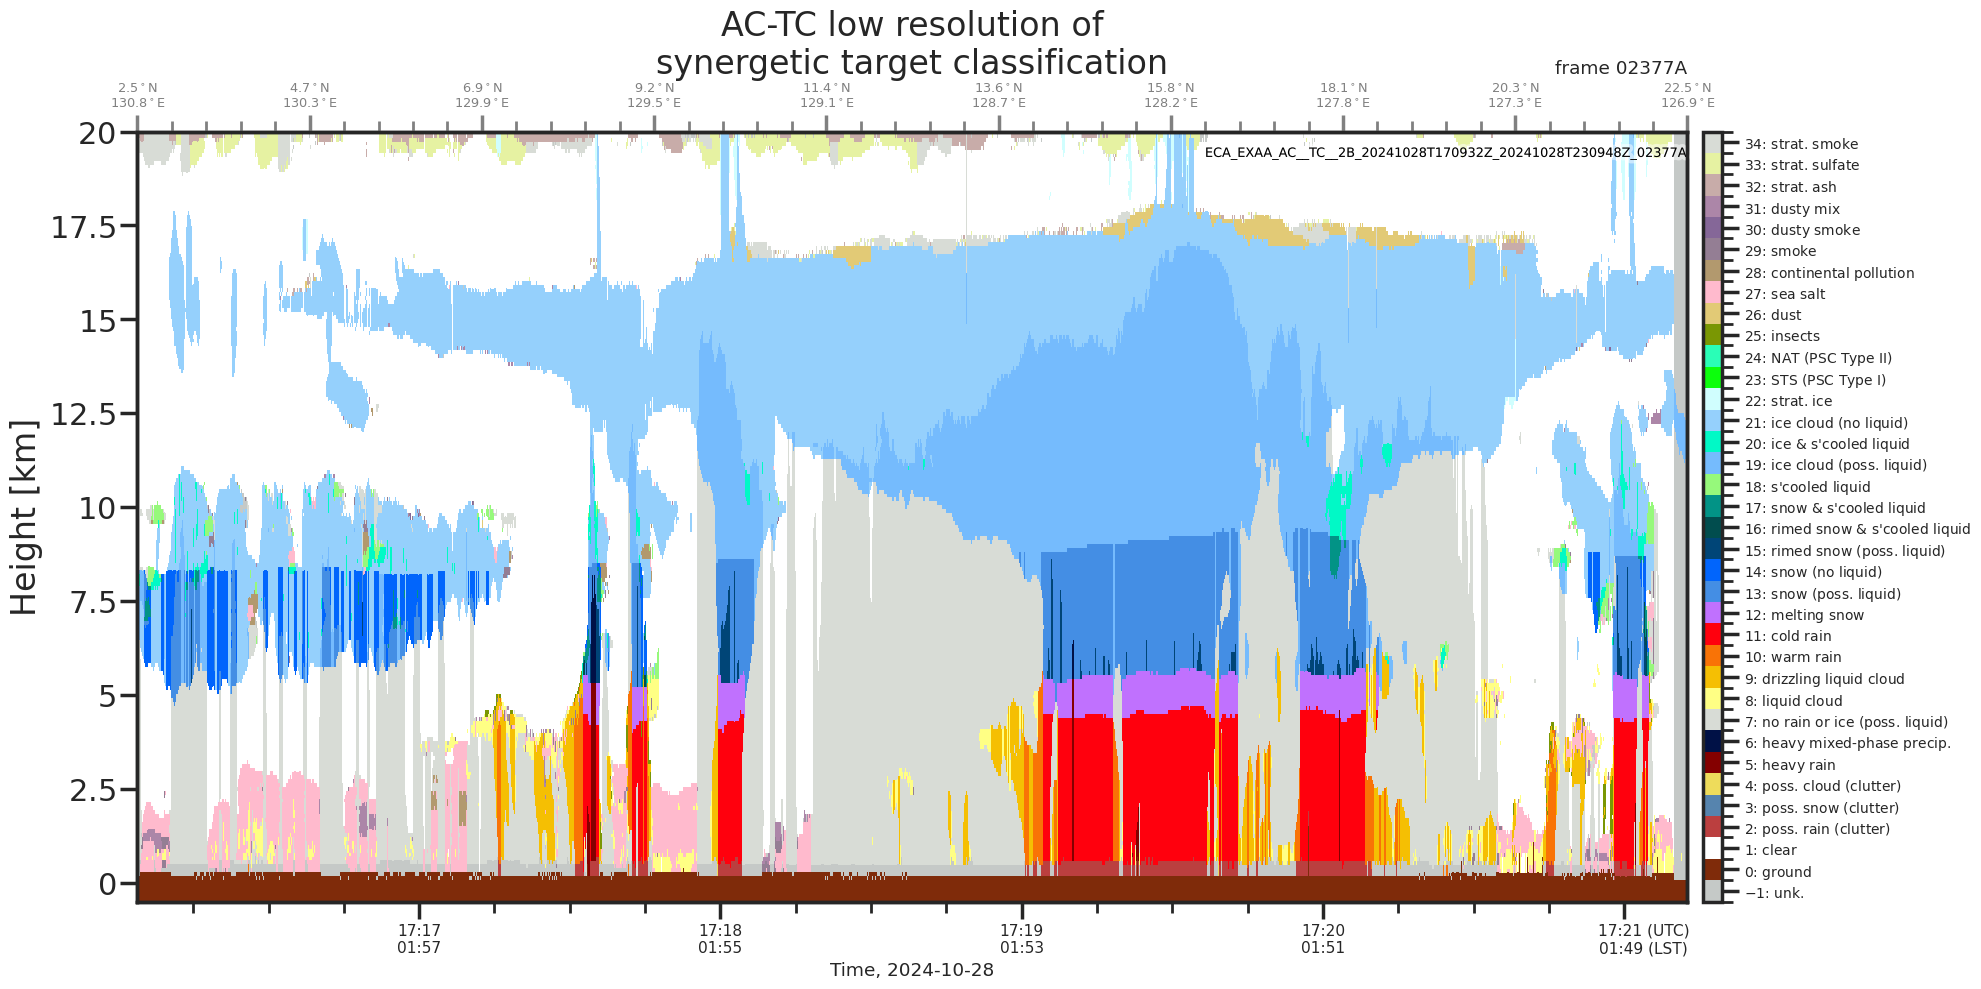

In [8]:
fig, ax  = plt.subplots(figsize=(20, 10))

ecplt.plot_EC_target_classification(ax, ACTC, 'synergetic_target_classification_low_resolution', ACTC_category_colors, title_prefix="", label_fontsize=10, hmax=hmax)

# plt.savefig(PTHS['sav_dir'] + 'Leslie_Classification', bbox_inches='tight')